In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import seaborn as sns
import os
import time
import seaborn as sns

In [24]:
# Set random seed for reproducibility
random_state = 42
random.seed(random_state)

In [25]:
path='/home/jupyter/Patch_extraction/'
base = '/home/jupyter/Patch_extraction/'

In [26]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [27]:
def patch_selection(ids, class_index):
    patch_paths = []
    labels = []
    slide_ids = []

    for slide_id in tqdm(ids):
        try:
            files1 = os.listdir(os.path.join(base, str(class_index), slide_id))
            
           # Randomly select 100 images if there are more than 100
            # if len(files1) > 100:
            #     selected_files = random.sample(files1, 100)
            # else:
            selected_files = files1  # Optionally limit the number of files selected

            for x in selected_files:
                patch_paths.append(os.path.join(base, str(class_index), slide_id, x))
                labels.append(class_index)  # Append the class label based on the folder name
                slide_ids.append(slide_id)  # Append the slide ID
        except FileNotFoundError:
            pass

    return patch_paths, labels, slide_ids

In [28]:
def patch_selection_remaining(ids, class_index):
    patch_paths = []
    labels = []
    slide_ids = []

    for slide_id in tqdm(ids):
        try:
            files1 = os.listdir(os.path.join(base, str(class_index), slide_id))
            
           # Randomly select 100 images if there are more than 100
            if len(files1) > 100:
                selected_files = random.sample(files1, 100)
            else:
                selected_files = files1  # Optionally limit the number of files selected

            for x in selected_files:
                patch_paths.append(os.path.join(base, str(class_index), slide_id, x))
                labels.append(class_index)  # Append the class label based on the folder name
                slide_ids.append(slide_id)  # Append the slide ID
        except FileNotFoundError:
            pass

    return patch_paths, labels, slide_ids

In [29]:
train_patch_ids = []
train_labels = []
train_slide_ids = []

val_patch_ids = []
val_labels = []
val_slide_ids = []

test_patch_ids = []
test_labels = []
test_slide_ids = []

remaining_patch_ids = []
remaining_labels = []
remaining_slide_ids = []


for i in range(0, 17):
    # List all file IDs in the directory
    ids = os.listdir(base + '/' + str(i) + '/')
    ids_1=ids
    
    # Ensure at most 10 slides are selected
    if len(ids) > 10:
        ids = random.sample(ids, 10)

    # Split the IDs into training, validation, and test sets
    train_ids_1, test_ids = train_test_split(ids, test_size=0.30, random_state=42)
    train_ids, val_ids = train_test_split(train_ids_1, test_size=0.20, random_state=42)
    
    # Get remaining slides
    selected_ids = set(train_ids + val_ids)
    remaining_ids = [id_ for id_ in ids_1 if id_ not in selected_ids]
    
    # Assuming patch_selection function selects patches from given ids and class index
    train_patch_id, train_label, train_slide_id = patch_selection(train_ids, i)
    val_patch_id, val_label, val_slide_id = patch_selection(val_ids, i)
    test_patch_id, test_label, test_slide_id = patch_selection(test_ids, i)
    remaining_patch_id, remaining_label, remaining_slide_id = patch_selection_remaining(remaining_ids, i)
    
    train_patch_ids.extend(train_patch_id)
    train_labels.extend(train_label)
    train_slide_ids.extend(train_slide_id)
    
    val_patch_ids.extend(val_patch_id)
    val_labels.extend(val_label)
    val_slide_ids.extend(val_slide_id)
    
    test_patch_ids.extend(test_patch_id)
    test_labels.extend(test_label)
    test_slide_ids.extend(test_slide_id)
    
    remaining_patch_ids.extend(remaining_patch_id)
    remaining_labels.extend(remaining_label)
    remaining_slide_ids.extend(remaining_slide_id)

       
# Print some results to verify
print(f"Total training patches: {len(train_patch_ids)}")
print(f"Total validation patches: {len(val_patch_ids)}")
print(f"Total testing patches: {len(test_patch_ids)}")
print(f"Total remaining patches: {len(remaining_patch_ids)}")

100%|██████████| 3/3 [00:00<00:00, 409.47it/s]

Total training patches: 212398
Total validation patches: 91208
Total testing patches: 132926
Total remaining patches: 87714


In [30]:
# # Define transformations
# transform = transforms.ToTensor()


# # Function to calculate mean and std
# def calculate_mean_std(image_paths):
#     mean = np.zeros(3)
#     std = np.zeros(3)
#     num_images = len(image_paths)

#     for img_path in image_paths:
#         image = Image.open(img_path)
#         tensor = transform(image)
#         mean += tensor.mean([1, 2]).numpy()
#         std += tensor.std([1, 2]).numpy()

#     mean /= num_images
#     std /= num_images

#     return mean, std


# # Combine all image paths
# all_image_paths = train_patch_ids + val_patch_ids + test_patch_ids

# # Calculate mean and std
# mean, std = calculate_mean_std(all_image_paths)

# print(f'Mean: {mean}')
# print(f'Std: {std}')

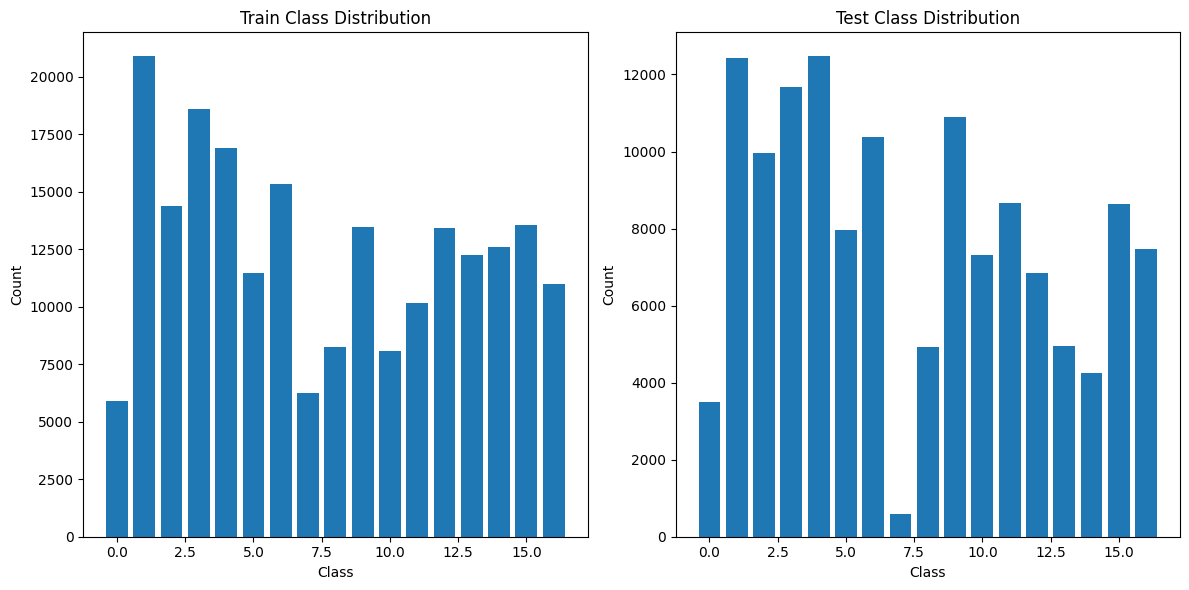

Train class distribution: [ 5908. 20881. 14361. 18596. 16889. 11458. 15321.  6227.  8234. 13464.
  8082. 10179. 13422. 12248. 12609. 13530. 10989.]
Test class distribution: [ 3500. 12420.  9949. 11666. 12470.  7957. 10385.   602.  4926. 10904.
  7325.  8676.  6842.  4951.  4251.  8642.  7460.]


In [31]:
def get_class_distribution_from_filenames(filenames, custom_classes):
    class_counts = np.zeros(len(custom_classes))
    class_map = {cls: idx for idx, cls in enumerate(custom_classes)}
    
    for filename in filenames:
        # Extract class label from the directory name
        class_label = int(os.path.basename(os.path.dirname(os.path.dirname(filename))))
        if class_label in class_map:
            class_counts[class_map[class_label]] += 1
    
    return class_counts

# Define your custom range of class labels
custom_range = list(range(0, 17))

# Assuming train_patch_ids and test_patch_ids are lists of image paths for training and testing
train_class_distribution = get_class_distribution_from_filenames(train_patch_ids, custom_range)
test_class_distribution = get_class_distribution_from_filenames(test_patch_ids, custom_range)

# Plotting class distributions
classes = np.array(custom_range)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(classes, train_class_distribution)
plt.title('Train Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(classes, test_class_distribution)

plt.title('Test Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Print distributions as arrays
print("Train class distribution:", train_class_distribution)
print("Test class distribution:", test_class_distribution)


In [32]:

# Assuming train_patch_ids, train_labels, train_slide_ids, test_patch_ids, test_labels, and test_slide_ids are lists of image paths, labels, and slide IDs for training and testing
# Create dataset and dataloader
class TissueDataset(Dataset):
    def __init__(self, image_paths, labels, slide_ids, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.slide_ids = slide_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        slide_id = self.slide_ids[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, slide_id
 


In [33]:
# Define the data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Create dataset and dataloader
train_dataset = TissueDataset(train_patch_ids, train_labels, train_slide_ids, transform=train_transform)
val_dataset = TissueDataset(val_patch_ids, val_labels, val_slide_ids, transform=val_transform)
test_dataset = TissueDataset(test_patch_ids, test_labels, test_slide_ids, transform=val_transform)
remaining_dataset = TissueDataset(remaining_patch_ids, remaining_labels, remaining_slide_ids, transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)
remaining_loader = DataLoader(remaining_dataset, batch_size=128, shuffle=False, num_workers=4)



In [34]:
print(len(train_loader))

1660


In [35]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [36]:
def training(train_loader, val_loader, learn_rate, EPOCHS, model, filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Use DataParallel for multi-GPU support
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs")
        model = nn.DataParallel(model)

    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learn_rate)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        epoch_start_time = time.time()

        # Initialize tqdm progress bar
        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', unit='batch')

        for batch_idx, (inputs, labels, slide_ids) in enumerate(train_loader_tqdm):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            batch_loss = running_loss / ((batch_idx + 1) * train_loader.batch_size)
            batch_acc = running_corrects.double() / ((batch_idx + 1) * train_loader.batch_size)

            # Calculate and display ETA
            batch_end_time = time.time()
            batch_duration = batch_end_time - epoch_start_time
            eta = batch_duration * (len(train_loader) - batch_idx - 1) / (batch_idx + 1)

            # Update tqdm progress bar with current loss, accuracy, and ETA
            train_loader_tqdm.set_postfix(
                loss=batch_loss,
                accuracy=batch_acc.item(),
                ETA=f"{eta/60:.2f} min"
            )

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels, slide_ids in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")

        # Save the model at the end of each epoch if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch+1} epochs")
            break

    return model

In [37]:
# class ClassificationModel(nn.Module):
#     def __init__(self, num_classes=17):
#         super(ClassificationModel, self).__init__()
#         base_model = models.efficientnet_b0(pretrained=True)
#         self.features = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the classifier layer
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(base_model.classifier[1].in_features, 2048),
#             nn.ReLU(),
#             nn.BatchNorm1d(2048),
#             nn.Dropout(0.5),
#             nn.Linear(2048, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.classifier(x)
#         return x

# def freezing_layers(model):
#     for param in model.features.parameters():
#         param.requires_grad = False

In [38]:
class ClassificationModel(nn.Module):
    def __init__(self, num_classes=17):
        super(ClassificationModel, self).__init__()
        base_model = models.efficientnet_b0(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-1])  # Exclude the classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base_model.classifier[1].in_features, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def freezing_layers(model):
    for param in model.features.parameters():
        param.requires_grad = False


In [ ]:
# model = ClassificationModel(num_classes=17)
# freezing_layers(model)

# learn_rate = 0.001
# EPOCHS = 2
# filename = 'efficientnet_b0.pth'

# model = training(train_loader, val_loader, learn_rate, EPOCHS, model, filename)



/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Epoch 1/2: 100%|██████████| 1660/1660 [7:28:05<00:00, 16.20s/batch, ETA=0.00 min, accuracy=0.774, loss=0.744]    

Epoch 1/2, Loss: 0.7438, Acc: 0.7743


Validation Loss: 2.6841, Validation Acc: 0.4668


Epoch 2/2:   5%|▌         | 90/1660 [24:26<7:05:49, 16.27s/batch, ETA=426.25 min, accuracy=0.825, loss=0.594]

In [39]:
# Load the best model for evaluation
filename = 'efficientnet_b0_v2.pth'

model = ClassificationModel(num_classes=17)

# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

    
model.load_state_dict(torch.load(filename))


# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)


model.eval()


test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []
slide_predictions = defaultdict(list)
slide_labels = {}

# Evaluation loop
with torch.no_grad():
    for inputs, labels, slide_ids in tqdm(test_loader, desc="Evaluating", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store predictions for each slide
        for slide_id, pred, label in zip(slide_ids, preds.cpu().numpy(), labels.cpu().numpy()):
            slide_predictions[slide_id].append(pred)
            slide_labels[slide_id] = label

        # Calculate current accuracy
        current_acc = test_corrects.double() / len(all_labels)

        # Update the progress bar with current accuracy
        tqdm.write(f"Batch Loss: {test_loss / len(all_labels):.4f}, Batch Accuracy: {current_acc.item():.4f}")



Evaluating:   0%|          | 0/1039 [00:23<?, ?batch/s]


KeyboardInterrupt: 

In [ ]:
test_loss /= len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Patch-level Classification Report and Confusion Matrix
print("\nPatch-level Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(17)]))

cm_patch = confusion_matrix(all_labels, all_preds)
cm_patch_percentage = cm_patch.astype('float') / cm_patch.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_patch_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(17)], yticklabels=[str(i) for i in range(17)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Patch-level Confusion Matrix (in %)')
plt.show()

# Generate slide-level predictions
slide_preds = {}
for slide_id, preds in slide_predictions.items():
    # Majority vote or averaging probabilities can be used
    slide_preds[slide_id] = Counter(preds).most_common(1)[0][0]  # Majority vote

# Prepare slide-level true labels and predictions for evaluation
slide_true_labels = [label for slide_id, label in slide_labels.items()]
slide_pred_labels = [pred for slide_id, pred in slide_preds.items()]

# Calculate slide-level accuracy
slide_corrects = sum([1 if pred == true else 0 for pred, true in zip(slide_pred_labels, slide_true_labels)])
slide_accuracy = slide_corrects / len(slide_true_labels)

print(f"Slide-level Accuracy: {slide_accuracy:.4f}")

# Slide-level Classification Report and Confusion Matrix
print("\nSlide-level Classification Report:\n")
print(classification_report(slide_true_labels, slide_pred_labels, target_names=[str(i) for i in range(17)]))

cm_slide = confusion_matrix(slide_true_labels, slide_pred_labels)
cm_slide_percentage = cm_slide.astype('float') / cm_slide.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_slide_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(17)], yticklabels=[str(i) for i in range(17)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Slide-level Confusion Matrix (in %)')
plt.show()


In [ ]:
# Load the best model for evaluation
# filename = 'efficientnet_b0.pth'

# model = ClassificationModel(num_classes=17)

# # Use DataParallel for multi-GPU support
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)

    
# model.load_state_dict(torch.load(filename))


# # Use DataParallel for multi-GPU support
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = nn.DataParallel(model)


# model.eval()

In [40]:
test_loss = 0.0
test_corrects = 0
all_preds = []
all_labels = []
slide_predictions = defaultdict(list)
slide_labels = {}

# Evaluation loop
with torch.no_grad():
    for inputs, labels, slide_ids in tqdm(remaining_loader, desc="Evaluating", unit="batch"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store predictions for each slide
        for slide_id, pred, label in zip(slide_ids, preds.cpu().numpy(), labels.cpu().numpy()):
            slide_predictions[slide_id].append(pred)
            slide_labels[slide_id] = label

        # Calculate current accuracy
        current_acc = test_corrects.double() / len(all_labels)

        # Update the progress bar with current accuracy
        tqdm.write(f"Batch Loss: {test_loss / len(all_labels):.4f}, Batch Accuracy: {current_acc.item():.4f}")



Evaluating:   0%|          | 1/686 [00:28<5:22:05, 28.21s/batch]

Batch Loss: 4.9859, Batch Accuracy: 0.0391


Evaluating:   0%|          | 2/686 [00:49<4:33:51, 24.02s/batch]

Batch Loss: 3.7177, Batch Accuracy: 0.1641


Evaluating:   0%|          | 3/686 [01:09<4:13:01, 22.23s/batch]

Batch Loss: 4.0240, Batch Accuracy: 0.1719


Evaluating:   1%|          | 4/686 [01:31<4:10:22, 22.03s/batch]

Batch Loss: 4.3852, Batch Accuracy: 0.1328


Evaluating:   1%|          | 5/686 [01:52<4:05:33, 21.64s/batch]

Batch Loss: 4.4001, Batch Accuracy: 0.1437


Evaluating:   1%|          | 6/686 [02:14<4:09:07, 21.98s/batch]

Batch Loss: 4.4123, Batch Accuracy: 0.1602


Evaluating:   1%|          | 7/686 [02:36<4:09:43, 22.07s/batch]

Batch Loss: 5.1848, Batch Accuracy: 0.1384


Evaluating:   1%|          | 8/686 [02:58<4:07:56, 21.94s/batch]

Batch Loss: 5.1958, Batch Accuracy: 0.1562


Evaluating:   1%|▏         | 9/686 [03:20<4:07:13, 21.91s/batch]

Batch Loss: 4.9065, Batch Accuracy: 0.1884


Evaluating:   1%|▏         | 10/686 [03:41<4:02:34, 21.53s/batch]

Batch Loss: 5.0806, Batch Accuracy: 0.1820


Evaluating:   2%|▏         | 11/686 [04:00<3:55:14, 20.91s/batch]

Batch Loss: 4.8974, Batch Accuracy: 0.1946


Evaluating:   2%|▏         | 12/686 [04:21<3:55:37, 20.98s/batch]

Batch Loss: 4.8083, Batch Accuracy: 0.1849


Evaluating:   2%|▏         | 13/686 [04:43<3:57:18, 21.16s/batch]

Batch Loss: 4.6368, Batch Accuracy: 0.1995


Evaluating:   2%|▏         | 14/686 [05:04<3:57:57, 21.25s/batch]

Batch Loss: 4.8142, Batch Accuracy: 0.2009


Evaluating:   2%|▏         | 15/686 [05:25<3:54:34, 20.98s/batch]

Batch Loss: 4.6973, Batch Accuracy: 0.2062


Evaluating:   2%|▏         | 16/686 [05:45<3:51:36, 20.74s/batch]

Batch Loss: 4.5307, Batch Accuracy: 0.2202


Evaluating:   2%|▏         | 17/686 [06:06<3:53:46, 20.97s/batch]

Batch Loss: 4.4791, Batch Accuracy: 0.2142


Evaluating:   3%|▎         | 18/686 [06:28<3:54:32, 21.07s/batch]

Batch Loss: 4.3622, Batch Accuracy: 0.2235


Evaluating:   3%|▎         | 19/686 [06:49<3:53:30, 21.01s/batch]

Batch Loss: 4.2856, Batch Accuracy: 0.2196


Evaluating:   3%|▎         | 20/686 [07:09<3:52:05, 20.91s/batch]

Batch Loss: 4.2880, Batch Accuracy: 0.2145


Evaluating:   3%|▎         | 21/686 [07:30<3:51:15, 20.87s/batch]

Batch Loss: 4.3443, Batch Accuracy: 0.2057


Evaluating:   3%|▎         | 22/686 [07:51<3:50:48, 20.86s/batch]

Batch Loss: 4.2591, Batch Accuracy: 0.2120


Evaluating:   3%|▎         | 23/686 [08:13<3:54:37, 21.23s/batch]

Batch Loss: 4.2635, Batch Accuracy: 0.2126


Evaluating:   3%|▎         | 24/686 [08:35<3:56:22, 21.42s/batch]

Batch Loss: 4.1794, Batch Accuracy: 0.2155


Evaluating:   4%|▎         | 25/686 [08:56<3:56:30, 21.47s/batch]

Batch Loss: 4.0606, Batch Accuracy: 0.2331


Evaluating:   4%|▍         | 26/686 [09:17<3:54:57, 21.36s/batch]

Batch Loss: 4.1202, Batch Accuracy: 0.2290


Evaluating:   4%|▍         | 27/686 [09:38<3:50:20, 20.97s/batch]

Batch Loss: 4.0326, Batch Accuracy: 0.2410


Evaluating:   4%|▍         | 28/686 [09:59<3:50:16, 21.00s/batch]

Batch Loss: 3.9209, Batch Accuracy: 0.2573


Evaluating:   4%|▍         | 29/686 [10:20<3:52:15, 21.21s/batch]

Batch Loss: 3.9214, Batch Accuracy: 0.2532


Evaluating:   4%|▍         | 30/686 [10:42<3:52:23, 21.26s/batch]

Batch Loss: 4.1143, Batch Accuracy: 0.2448


Evaluating:   5%|▍         | 31/686 [11:03<3:51:41, 21.22s/batch]

Batch Loss: 4.3015, Batch Accuracy: 0.2369


Evaluating:   5%|▍         | 32/686 [11:24<3:50:05, 21.11s/batch]

Batch Loss: 4.3704, Batch Accuracy: 0.2295


Evaluating:   5%|▍         | 33/686 [11:44<3:48:30, 21.00s/batch]

Batch Loss: 4.4859, Batch Accuracy: 0.2268


Evaluating:   5%|▍         | 34/686 [12:06<3:49:13, 21.09s/batch]

Batch Loss: 4.4012, Batch Accuracy: 0.2353


Evaluating:   5%|▌         | 35/686 [12:27<3:50:34, 21.25s/batch]

Batch Loss: 4.3841, Batch Accuracy: 0.2333


Evaluating:   5%|▌         | 36/686 [12:47<3:46:06, 20.87s/batch]

Batch Loss: 4.3758, Batch Accuracy: 0.2320


Evaluating:   5%|▌         | 37/686 [13:08<3:46:17, 20.92s/batch]

Batch Loss: 4.4571, Batch Accuracy: 0.2261


Evaluating:   6%|▌         | 38/686 [13:29<3:43:39, 20.71s/batch]

Batch Loss: 4.5425, Batch Accuracy: 0.2210


Evaluating:   6%|▌         | 39/686 [13:50<3:45:37, 20.92s/batch]

Batch Loss: 4.5315, Batch Accuracy: 0.2228


Evaluating:   6%|▌         | 40/686 [14:12<3:48:51, 21.26s/batch]

Batch Loss: 4.5255, Batch Accuracy: 0.2230


Evaluating:   6%|▌         | 41/686 [14:34<3:50:18, 21.42s/batch]

Batch Loss: 4.4595, Batch Accuracy: 0.2281


Evaluating:   6%|▌         | 42/686 [14:54<3:47:24, 21.19s/batch]

Batch Loss: 4.4844, Batch Accuracy: 0.2243


Evaluating:   6%|▋         | 43/686 [15:15<3:45:27, 21.04s/batch]

Batch Loss: 4.4881, Batch Accuracy: 0.2277


Evaluating:   6%|▋         | 44/686 [15:36<3:44:37, 20.99s/batch]

Batch Loss: 4.4530, Batch Accuracy: 0.2290


Evaluating:   7%|▋         | 45/686 [15:57<3:44:30, 21.01s/batch]

Batch Loss: 4.4343, Batch Accuracy: 0.2283


Evaluating:   7%|▋         | 46/686 [16:19<3:45:45, 21.16s/batch]

Batch Loss: 4.4679, Batch Accuracy: 0.2250


Evaluating:   7%|▋         | 47/686 [16:40<3:45:36, 21.18s/batch]

Batch Loss: 4.4386, Batch Accuracy: 0.2271


Evaluating:   7%|▋         | 48/686 [17:00<3:41:31, 20.83s/batch]

Batch Loss: 4.4012, Batch Accuracy: 0.2327


Evaluating:   7%|▋         | 49/686 [17:21<3:40:37, 20.78s/batch]

Batch Loss: 4.3838, Batch Accuracy: 0.2333


Evaluating:   7%|▋         | 50/686 [17:41<3:40:49, 20.83s/batch]

Batch Loss: 4.3392, Batch Accuracy: 0.2348


Evaluating:   7%|▋         | 51/686 [18:03<3:43:05, 21.08s/batch]

Batch Loss: 4.3482, Batch Accuracy: 0.2335


Evaluating:   8%|▊         | 52/686 [18:25<3:44:57, 21.29s/batch]

Batch Loss: 4.3185, Batch Accuracy: 0.2342


Evaluating:   8%|▊         | 53/686 [18:47<3:46:51, 21.50s/batch]

Batch Loss: 4.3741, Batch Accuracy: 0.2307


Evaluating:   8%|▊         | 54/686 [19:07<3:43:19, 21.20s/batch]

Batch Loss: 4.3713, Batch Accuracy: 0.2287


Evaluating:   8%|▊         | 55/686 [19:28<3:41:16, 21.04s/batch]

Batch Loss: 4.3312, Batch Accuracy: 0.2322


Evaluating:   8%|▊         | 56/686 [19:49<3:42:11, 21.16s/batch]

Batch Loss: 4.2943, Batch Accuracy: 0.2372


Evaluating:   8%|▊         | 57/686 [20:11<3:42:27, 21.22s/batch]

Batch Loss: 4.2488, Batch Accuracy: 0.2415


Evaluating:   8%|▊         | 58/686 [20:32<3:41:39, 21.18s/batch]

Batch Loss: 4.2068, Batch Accuracy: 0.2446


Evaluating:   9%|▊         | 59/686 [20:53<3:41:41, 21.21s/batch]

Batch Loss: 4.2111, Batch Accuracy: 0.2423


Evaluating:   9%|▊         | 60/686 [21:14<3:40:41, 21.15s/batch]

Batch Loss: 4.2735, Batch Accuracy: 0.2384


Evaluating:   9%|▉         | 61/686 [21:35<3:38:19, 20.96s/batch]

Batch Loss: 4.3392, Batch Accuracy: 0.2349


Evaluating:   9%|▉         | 62/686 [21:56<3:37:46, 20.94s/batch]

Batch Loss: 4.3369, Batch Accuracy: 0.2332


Evaluating:   9%|▉         | 63/686 [22:17<3:39:49, 21.17s/batch]

Batch Loss: 4.2917, Batch Accuracy: 0.2383


Evaluating:   9%|▉         | 64/686 [22:39<3:39:32, 21.18s/batch]

Batch Loss: 4.3035, Batch Accuracy: 0.2390


Evaluating:   9%|▉         | 65/686 [22:58<3:34:14, 20.70s/batch]

Batch Loss: 4.3785, Batch Accuracy: 0.2353


Evaluating:  10%|▉         | 66/686 [23:20<3:36:23, 20.94s/batch]

Batch Loss: 4.3872, Batch Accuracy: 0.2340


Evaluating:  10%|▉         | 67/686 [23:40<3:33:06, 20.66s/batch]

Batch Loss: 4.4074, Batch Accuracy: 0.2326


Evaluating:  10%|▉         | 68/686 [24:00<3:32:47, 20.66s/batch]

Batch Loss: 4.4260, Batch Accuracy: 0.2298


Evaluating:  10%|█         | 69/686 [24:21<3:33:28, 20.76s/batch]

Batch Loss: 4.4709, Batch Accuracy: 0.2283


Evaluating:  10%|█         | 70/686 [24:43<3:35:59, 21.04s/batch]

Batch Loss: 4.4372, Batch Accuracy: 0.2323


Evaluating:  10%|█         | 71/686 [25:04<3:35:31, 21.03s/batch]

Batch Loss: 4.4139, Batch Accuracy: 0.2331


Evaluating:  10%|█         | 72/686 [25:24<3:32:47, 20.79s/batch]

Batch Loss: 4.3854, Batch Accuracy: 0.2349


Evaluating:  11%|█         | 73/686 [25:45<3:32:26, 20.79s/batch]

Batch Loss: 4.3535, Batch Accuracy: 0.2376


Evaluating:  11%|█         | 74/686 [26:06<3:31:23, 20.73s/batch]

Batch Loss: 4.3165, Batch Accuracy: 0.2424


Evaluating:  11%|█         | 75/686 [26:27<3:32:06, 20.83s/batch]

Batch Loss: 4.3419, Batch Accuracy: 0.2411


Evaluating:  11%|█         | 76/686 [26:48<3:33:30, 21.00s/batch]

Batch Loss: 4.3336, Batch Accuracy: 0.2409


Evaluating:  11%|█         | 77/686 [27:08<3:29:28, 20.64s/batch]

Batch Loss: 4.3448, Batch Accuracy: 0.2431


Evaluating:  11%|█▏        | 78/686 [27:28<3:27:25, 20.47s/batch]

Batch Loss: 4.3524, Batch Accuracy: 0.2443


Evaluating:  12%|█▏        | 79/686 [27:48<3:27:21, 20.50s/batch]

Batch Loss: 4.3148, Batch Accuracy: 0.2496


Evaluating:  12%|█▏        | 80/686 [28:10<3:30:59, 20.89s/batch]

Batch Loss: 4.3225, Batch Accuracy: 0.2474


Evaluating:  12%|█▏        | 81/686 [28:32<3:32:09, 21.04s/batch]

Batch Loss: 4.3096, Batch Accuracy: 0.2464


Evaluating:  12%|█▏        | 82/686 [28:52<3:30:53, 20.95s/batch]

Batch Loss: 4.3035, Batch Accuracy: 0.2463


Evaluating:  12%|█▏        | 83/686 [29:13<3:30:06, 20.91s/batch]

Batch Loss: 4.2636, Batch Accuracy: 0.2519


Evaluating:  12%|█▏        | 84/686 [29:35<3:31:04, 21.04s/batch]

Batch Loss: 4.2484, Batch Accuracy: 0.2532


Evaluating:  12%|█▏        | 85/686 [29:56<3:30:44, 21.04s/batch]

Batch Loss: 4.2471, Batch Accuracy: 0.2523


Evaluating:  13%|█▎        | 86/686 [30:17<3:30:39, 21.07s/batch]

Batch Loss: 4.2594, Batch Accuracy: 0.2500


Evaluating:  13%|█▎        | 87/686 [30:37<3:28:36, 20.90s/batch]

Batch Loss: 4.2670, Batch Accuracy: 0.2488


Evaluating:  13%|█▎        | 88/686 [30:57<3:25:19, 20.60s/batch]

Batch Loss: 4.2672, Batch Accuracy: 0.2472


Evaluating:  13%|█▎        | 89/686 [31:19<3:27:21, 20.84s/batch]

Batch Loss: 4.3160, Batch Accuracy: 0.2449


Evaluating:  13%|█▎        | 90/686 [31:40<3:28:08, 20.95s/batch]

Batch Loss: 4.2991, Batch Accuracy: 0.2450


Evaluating:  13%|█▎        | 91/686 [32:01<3:28:40, 21.04s/batch]

Batch Loss: 4.2955, Batch Accuracy: 0.2439


Evaluating:  13%|█▎        | 92/686 [32:23<3:31:36, 21.37s/batch]

Batch Loss: 4.2674, Batch Accuracy: 0.2475


Evaluating:  14%|█▎        | 93/686 [32:44<3:30:31, 21.30s/batch]

Batch Loss: 4.2492, Batch Accuracy: 0.2485


Evaluating:  14%|█▎        | 94/686 [33:05<3:27:53, 21.07s/batch]

Batch Loss: 4.2468, Batch Accuracy: 0.2478


Evaluating:  14%|█▍        | 95/686 [33:24<3:22:33, 20.57s/batch]

Batch Loss: 4.2332, Batch Accuracy: 0.2479


Evaluating:  14%|█▍        | 96/686 [33:46<3:25:16, 20.87s/batch]

Batch Loss: 4.2229, Batch Accuracy: 0.2480


Evaluating:  14%|█▍        | 97/686 [34:07<3:24:43, 20.85s/batch]

Batch Loss: 4.2177, Batch Accuracy: 0.2474


Evaluating:  14%|█▍        | 98/686 [34:28<3:25:54, 21.01s/batch]

Batch Loss: 4.2076, Batch Accuracy: 0.2472


Evaluating:  14%|█▍        | 99/686 [34:49<3:24:13, 20.87s/batch]

Batch Loss: 4.1829, Batch Accuracy: 0.2489


Evaluating:  15%|█▍        | 100/686 [35:09<3:23:03, 20.79s/batch]

Batch Loss: 4.1861, Batch Accuracy: 0.2475


Evaluating:  15%|█▍        | 101/686 [35:30<3:23:44, 20.90s/batch]

Batch Loss: 4.1963, Batch Accuracy: 0.2457


Evaluating:  15%|█▍        | 102/686 [35:51<3:23:33, 20.91s/batch]

Batch Loss: 4.2335, Batch Accuracy: 0.2433


Evaluating:  15%|█▌        | 103/686 [36:13<3:25:19, 21.13s/batch]

Batch Loss: 4.2369, Batch Accuracy: 0.2458


Evaluating:  15%|█▌        | 104/686 [36:34<3:23:43, 21.00s/batch]

Batch Loss: 4.2314, Batch Accuracy: 0.2452


Evaluating:  15%|█▌        | 105/686 [36:54<3:22:40, 20.93s/batch]

Batch Loss: 4.2280, Batch Accuracy: 0.2449


Evaluating:  15%|█▌        | 106/686 [37:15<3:20:46, 20.77s/batch]

Batch Loss: 4.2154, Batch Accuracy: 0.2469


Evaluating:  16%|█▌        | 107/686 [37:36<3:20:43, 20.80s/batch]

Batch Loss: 4.2019, Batch Accuracy: 0.2476


Evaluating:  16%|█▌        | 108/686 [37:57<3:21:20, 20.90s/batch]

Batch Loss: 4.1830, Batch Accuracy: 0.2506


Evaluating:  16%|█▌        | 109/686 [38:19<3:24:30, 21.27s/batch]

Batch Loss: 4.2117, Batch Accuracy: 0.2485


Evaluating:  16%|█▌        | 110/686 [38:40<3:23:14, 21.17s/batch]

Batch Loss: 4.2107, Batch Accuracy: 0.2496


Evaluating:  16%|█▌        | 111/686 [38:58<3:14:49, 20.33s/batch]

Batch Loss: 4.2918, Batch Accuracy: 0.2480


Evaluating:  16%|█▋        | 112/686 [39:19<3:16:37, 20.55s/batch]

Batch Loss: 4.2950, Batch Accuracy: 0.2464


Evaluating:  16%|█▋        | 113/686 [39:41<3:19:08, 20.85s/batch]

Batch Loss: 4.2912, Batch Accuracy: 0.2453


Evaluating:  17%|█▋        | 114/686 [40:02<3:20:35, 21.04s/batch]

Batch Loss: 4.2981, Batch Accuracy: 0.2436


Evaluating:  17%|█▋        | 115/686 [40:24<3:21:14, 21.15s/batch]

Batch Loss: 4.2874, Batch Accuracy: 0.2438


Evaluating:  17%|█▋        | 116/686 [40:44<3:19:34, 21.01s/batch]

Batch Loss: 4.2980, Batch Accuracy: 0.2423


Evaluating:  17%|█▋        | 117/686 [41:04<3:14:25, 20.50s/batch]

Batch Loss: 4.2867, Batch Accuracy: 0.2413


Evaluating:  17%|█▋        | 118/686 [41:25<3:17:12, 20.83s/batch]

Batch Loss: 4.2907, Batch Accuracy: 0.2397


Evaluating:  17%|█▋        | 119/686 [41:47<3:18:23, 20.99s/batch]

Batch Loss: 4.2812, Batch Accuracy: 0.2409


Evaluating:  17%|█▋        | 120/686 [42:09<3:21:56, 21.41s/batch]

Batch Loss: 4.2652, Batch Accuracy: 0.2415


Evaluating:  18%|█▊        | 121/686 [42:30<3:19:06, 21.14s/batch]

Batch Loss: 4.3260, Batch Accuracy: 0.2404


Evaluating:  18%|█▊        | 122/686 [42:48<3:11:47, 20.40s/batch]

Batch Loss: 4.3169, Batch Accuracy: 0.2418


Evaluating:  18%|█▊        | 123/686 [43:10<3:13:55, 20.67s/batch]

Batch Loss: 4.3146, Batch Accuracy: 0.2408


Evaluating:  18%|█▊        | 124/686 [43:31<3:15:28, 20.87s/batch]

Batch Loss: 4.3193, Batch Accuracy: 0.2394


Evaluating:  18%|█▊        | 125/686 [43:53<3:17:20, 21.11s/batch]

Batch Loss: 4.3293, Batch Accuracy: 0.2376


Evaluating:  18%|█▊        | 126/686 [44:15<3:19:46, 21.40s/batch]

Batch Loss: 4.3087, Batch Accuracy: 0.2401


Evaluating:  19%|█▊        | 127/686 [44:36<3:18:33, 21.31s/batch]

Batch Loss: 4.3389, Batch Accuracy: 0.2394


Evaluating:  19%|█▊        | 128/686 [44:54<3:09:39, 20.39s/batch]

Batch Loss: 4.3686, Batch Accuracy: 0.2379


Evaluating:  19%|█▉        | 129/686 [45:16<3:12:42, 20.76s/batch]

Batch Loss: 4.3635, Batch Accuracy: 0.2372


Evaluating:  19%|█▉        | 130/686 [45:36<3:12:21, 20.76s/batch]

Batch Loss: 4.3886, Batch Accuracy: 0.2358


Evaluating:  19%|█▉        | 131/686 [45:57<3:11:32, 20.71s/batch]

Batch Loss: 4.3891, Batch Accuracy: 0.2352


Evaluating:  19%|█▉        | 132/686 [46:18<3:13:33, 20.96s/batch]

Batch Loss: 4.3944, Batch Accuracy: 0.2340


Evaluating:  19%|█▉        | 133/686 [46:39<3:11:21, 20.76s/batch]

Batch Loss: 4.3835, Batch Accuracy: 0.2343


Evaluating:  20%|█▉        | 134/686 [46:59<3:08:14, 20.46s/batch]

Batch Loss: 4.3871, Batch Accuracy: 0.2333


Evaluating:  20%|█▉        | 135/686 [47:20<3:09:29, 20.64s/batch]

Batch Loss: 4.3869, Batch Accuracy: 0.2326


Evaluating:  20%|█▉        | 136/686 [47:41<3:10:53, 20.82s/batch]

Batch Loss: 4.3694, Batch Accuracy: 0.2341


Evaluating:  20%|█▉        | 137/686 [48:01<3:08:16, 20.58s/batch]

Batch Loss: 4.3482, Batch Accuracy: 0.2365


Evaluating:  20%|██        | 138/686 [48:21<3:07:48, 20.56s/batch]

Batch Loss: 4.3284, Batch Accuracy: 0.2387


Evaluating:  20%|██        | 139/686 [48:41<3:03:40, 20.15s/batch]

Batch Loss: 4.3421, Batch Accuracy: 0.2380


Evaluating:  20%|██        | 140/686 [49:01<3:03:05, 20.12s/batch]

Batch Loss: 4.3362, Batch Accuracy: 0.2381


Evaluating:  21%|██        | 141/686 [49:23<3:07:35, 20.65s/batch]

Batch Loss: 4.3290, Batch Accuracy: 0.2384


Evaluating:  21%|██        | 142/686 [49:43<3:07:06, 20.64s/batch]

Batch Loss: 4.3133, Batch Accuracy: 0.2400


Evaluating:  21%|██        | 143/686 [50:04<3:08:13, 20.80s/batch]

Batch Loss: 4.2968, Batch Accuracy: 0.2417


Evaluating:  21%|██        | 144/686 [50:24<3:05:41, 20.56s/batch]

Batch Loss: 4.2875, Batch Accuracy: 0.2420


Evaluating:  21%|██        | 145/686 [50:45<3:06:44, 20.71s/batch]

Batch Loss: 4.2913, Batch Accuracy: 0.2407


Evaluating:  21%|██▏       | 146/686 [51:06<3:06:24, 20.71s/batch]

Batch Loss: 4.2783, Batch Accuracy: 0.2411


Evaluating:  21%|██▏       | 147/686 [51:27<3:07:55, 20.92s/batch]

Batch Loss: 4.2711, Batch Accuracy: 0.2429


Evaluating:  22%|██▏       | 148/686 [51:48<3:06:11, 20.76s/batch]

Batch Loss: 4.3000, Batch Accuracy: 0.2413


Evaluating:  22%|██▏       | 149/686 [52:08<3:04:59, 20.67s/batch]

Batch Loss: 4.3118, Batch Accuracy: 0.2402


Evaluating:  22%|██▏       | 150/686 [52:29<3:05:13, 20.73s/batch]

Batch Loss: 4.3080, Batch Accuracy: 0.2397


Evaluating:  22%|██▏       | 151/686 [52:50<3:06:01, 20.86s/batch]

Batch Loss: 4.3110, Batch Accuracy: 0.2388


Evaluating:  22%|██▏       | 152/686 [53:12<3:08:57, 21.23s/batch]

Batch Loss: 4.2975, Batch Accuracy: 0.2392


Evaluating:  22%|██▏       | 153/686 [53:34<3:09:04, 21.29s/batch]

Batch Loss: 4.2828, Batch Accuracy: 0.2401


Evaluating:  22%|██▏       | 154/686 [53:53<3:03:14, 20.67s/batch]

Batch Loss: 4.2874, Batch Accuracy: 0.2393


Evaluating:  23%|██▎       | 155/686 [54:13<3:01:34, 20.52s/batch]

Batch Loss: 4.2866, Batch Accuracy: 0.2385


Evaluating:  23%|██▎       | 156/686 [54:34<3:01:13, 20.52s/batch]

Batch Loss: 4.2933, Batch Accuracy: 0.2377


Evaluating:  23%|██▎       | 157/686 [54:55<3:02:15, 20.67s/batch]

Batch Loss: 4.2757, Batch Accuracy: 0.2396


Evaluating:  23%|██▎       | 158/686 [55:17<3:05:25, 21.07s/batch]

Batch Loss: 4.2914, Batch Accuracy: 0.2381


Evaluating:  23%|██▎       | 159/686 [55:38<3:05:21, 21.10s/batch]

Batch Loss: 4.2834, Batch Accuracy: 0.2387


Evaluating:  23%|██▎       | 160/686 [55:57<2:58:19, 20.34s/batch]

Batch Loss: 4.2824, Batch Accuracy: 0.2390


Evaluating:  23%|██▎       | 161/686 [56:18<3:01:56, 20.79s/batch]

Batch Loss: 4.2787, Batch Accuracy: 0.2384


Evaluating:  24%|██▎       | 162/686 [56:40<3:03:47, 21.04s/batch]

Batch Loss: 4.2644, Batch Accuracy: 0.2398


Evaluating:  24%|██▍       | 163/686 [57:01<3:03:10, 21.01s/batch]

Batch Loss: 4.2488, Batch Accuracy: 0.2414


Evaluating:  24%|██▍       | 164/686 [57:24<3:07:40, 21.57s/batch]

Batch Loss: 4.2587, Batch Accuracy: 0.2409


Evaluating:  24%|██▍       | 165/686 [57:44<3:04:32, 21.25s/batch]

Batch Loss: 4.2493, Batch Accuracy: 0.2413


Evaluating:  24%|██▍       | 166/686 [58:05<3:01:26, 20.93s/batch]

Batch Loss: 4.2421, Batch Accuracy: 0.2413


Evaluating:  24%|██▍       | 167/686 [58:26<3:03:35, 21.22s/batch]

Batch Loss: 4.2328, Batch Accuracy: 0.2420


Evaluating:  24%|██▍       | 168/686 [58:48<3:03:47, 21.29s/batch]

Batch Loss: 4.2391, Batch Accuracy: 0.2409


Evaluating:  25%|██▍       | 169/686 [59:09<3:03:03, 21.24s/batch]

Batch Loss: 4.2242, Batch Accuracy: 0.2422


Evaluating:  25%|██▍       | 170/686 [59:30<3:02:16, 21.20s/batch]

Batch Loss: 4.2143, Batch Accuracy: 0.2429


Evaluating:  25%|██▍       | 171/686 [59:50<2:58:47, 20.83s/batch]

Batch Loss: 4.1989, Batch Accuracy: 0.2453


Evaluating:  25%|██▌       | 172/686 [1:00:12<3:00:27, 21.06s/batch]

Batch Loss: 4.1890, Batch Accuracy: 0.2455


Evaluating:  25%|██▌       | 173/686 [1:00:32<2:58:19, 20.86s/batch]

Batch Loss: 4.1918, Batch Accuracy: 0.2448


Evaluating:  25%|██▌       | 174/686 [1:00:53<2:57:18, 20.78s/batch]

Batch Loss: 4.1795, Batch Accuracy: 0.2455


Evaluating:  26%|██▌       | 175/686 [1:01:15<3:00:28, 21.19s/batch]

Batch Loss: 4.1855, Batch Accuracy: 0.2450


Evaluating:  26%|██▌       | 176/686 [1:01:36<3:00:28, 21.23s/batch]

Batch Loss: 4.1915, Batch Accuracy: 0.2447


Evaluating:  26%|██▌       | 177/686 [1:01:56<2:55:37, 20.70s/batch]

Batch Loss: 4.1884, Batch Accuracy: 0.2452


Evaluating:  26%|██▌       | 178/686 [1:02:18<2:58:46, 21.11s/batch]

Batch Loss: 4.1874, Batch Accuracy: 0.2450


Evaluating:  26%|██▌       | 179/686 [1:02:38<2:57:19, 20.98s/batch]

Batch Loss: 4.1812, Batch Accuracy: 0.2449


Evaluating:  26%|██▌       | 180/686 [1:02:59<2:56:43, 20.96s/batch]

Batch Loss: 4.1795, Batch Accuracy: 0.2449


Evaluating:  26%|██▋       | 181/686 [1:03:21<2:58:08, 21.17s/batch]

Batch Loss: 4.1724, Batch Accuracy: 0.2458


Evaluating:  27%|██▋       | 182/686 [1:03:41<2:55:55, 20.94s/batch]

Batch Loss: 4.1793, Batch Accuracy: 0.2448


Evaluating:  27%|██▋       | 183/686 [1:04:02<2:55:34, 20.94s/batch]

Batch Loss: 4.1642, Batch Accuracy: 0.2468


Evaluating:  27%|██▋       | 184/686 [1:04:23<2:54:16, 20.83s/batch]

Batch Loss: 4.1530, Batch Accuracy: 0.2478


Evaluating:  27%|██▋       | 185/686 [1:04:44<2:54:20, 20.88s/batch]

Batch Loss: 4.1408, Batch Accuracy: 0.2487


Evaluating:  27%|██▋       | 186/686 [1:05:05<2:54:22, 20.93s/batch]

Batch Loss: 4.1359, Batch Accuracy: 0.2485


Evaluating:  27%|██▋       | 187/686 [1:05:25<2:53:07, 20.82s/batch]

Batch Loss: 4.1620, Batch Accuracy: 0.2472


Evaluating:  27%|██▋       | 188/686 [1:05:44<2:45:56, 19.99s/batch]

Batch Loss: 4.2028, Batch Accuracy: 0.2458


Evaluating:  28%|██▊       | 189/686 [1:06:05<2:49:01, 20.41s/batch]

Batch Loss: 4.2115, Batch Accuracy: 0.2450


Evaluating:  28%|██▊       | 190/686 [1:06:26<2:50:39, 20.65s/batch]

Batch Loss: 4.2072, Batch Accuracy: 0.2448


Evaluating:  28%|██▊       | 191/686 [1:06:47<2:51:43, 20.82s/batch]

Batch Loss: 4.2080, Batch Accuracy: 0.2449


Evaluating:  28%|██▊       | 192/686 [1:07:09<2:52:27, 20.95s/batch]

Batch Loss: 4.1919, Batch Accuracy: 0.2472


Evaluating:  28%|██▊       | 193/686 [1:07:30<2:53:08, 21.07s/batch]

Batch Loss: 4.1891, Batch Accuracy: 0.2473


Evaluating:  28%|██▊       | 194/686 [1:07:49<2:47:24, 20.42s/batch]

Batch Loss: 4.2238, Batch Accuracy: 0.2466


Evaluating:  28%|██▊       | 195/686 [1:08:11<2:50:28, 20.83s/batch]

Batch Loss: 4.2247, Batch Accuracy: 0.2466


Evaluating:  29%|██▊       | 196/686 [1:08:32<2:51:06, 20.95s/batch]

Batch Loss: 4.2244, Batch Accuracy: 0.2465


Evaluating:  29%|██▊       | 197/686 [1:08:53<2:52:18, 21.14s/batch]

Batch Loss: 4.2160, Batch Accuracy: 0.2468


Evaluating:  29%|██▉       | 198/686 [1:09:15<2:52:43, 21.24s/batch]

Batch Loss: 4.2155, Batch Accuracy: 0.2469


Evaluating:  29%|██▉       | 199/686 [1:09:35<2:50:12, 20.97s/batch]

Batch Loss: 4.2200, Batch Accuracy: 0.2461


Evaluating:  29%|██▉       | 200/686 [1:09:56<2:49:15, 20.90s/batch]

Batch Loss: 4.2271, Batch Accuracy: 0.2450


Evaluating:  29%|██▉       | 201/686 [1:10:17<2:49:30, 20.97s/batch]

Batch Loss: 4.2199, Batch Accuracy: 0.2453


Evaluating:  29%|██▉       | 202/686 [1:10:39<2:51:23, 21.25s/batch]

Batch Loss: 4.2097, Batch Accuracy: 0.2461


Evaluating:  30%|██▉       | 203/686 [1:11:01<2:52:33, 21.43s/batch]

Batch Loss: 4.2121, Batch Accuracy: 0.2452


Evaluating:  30%|██▉       | 204/686 [1:11:23<2:54:01, 21.66s/batch]

Batch Loss: 4.2067, Batch Accuracy: 0.2448


Evaluating:  30%|██▉       | 205/686 [1:11:42<2:46:40, 20.79s/batch]

Batch Loss: 4.2088, Batch Accuracy: 0.2439


Evaluating:  30%|███       | 206/686 [1:12:03<2:48:07, 21.02s/batch]

Batch Loss: 4.2072, Batch Accuracy: 0.2431


Evaluating:  30%|███       | 207/686 [1:12:25<2:48:50, 21.15s/batch]

Batch Loss: 4.1979, Batch Accuracy: 0.2438


Evaluating:  30%|███       | 208/686 [1:12:45<2:47:03, 20.97s/batch]

Batch Loss: 4.1871, Batch Accuracy: 0.2443


Evaluating:  30%|███       | 209/686 [1:13:06<2:46:58, 21.00s/batch]

Batch Loss: 4.1843, Batch Accuracy: 0.2438


Evaluating:  31%|███       | 210/686 [1:13:28<2:46:54, 21.04s/batch]

Batch Loss: 4.1802, Batch Accuracy: 0.2439


Evaluating:  31%|███       | 211/686 [1:13:46<2:41:03, 20.34s/batch]

Batch Loss: 4.1960, Batch Accuracy: 0.2430


Evaluating:  31%|███       | 212/686 [1:14:08<2:43:15, 20.66s/batch]

Batch Loss: 4.1828, Batch Accuracy: 0.2445


Evaluating:  31%|███       | 213/686 [1:14:29<2:45:32, 21.00s/batch]

Batch Loss: 4.1804, Batch Accuracy: 0.2456


Evaluating:  31%|███       | 214/686 [1:14:51<2:45:22, 21.02s/batch]

Batch Loss: 4.1732, Batch Accuracy: 0.2461


Evaluating:  31%|███▏      | 215/686 [1:15:13<2:48:05, 21.41s/batch]

Batch Loss: 4.1681, Batch Accuracy: 0.2460


Evaluating:  31%|███▏      | 216/686 [1:15:33<2:45:26, 21.12s/batch]

Batch Loss: 4.1550, Batch Accuracy: 0.2476


Evaluating:  32%|███▏      | 217/686 [1:15:52<2:38:48, 20.32s/batch]

Batch Loss: 4.1676, Batch Accuracy: 0.2481


Evaluating:  32%|███▏      | 218/686 [1:16:14<2:41:49, 20.75s/batch]

Batch Loss: 4.1661, Batch Accuracy: 0.2482


Evaluating:  32%|███▏      | 219/686 [1:16:34<2:41:16, 20.72s/batch]

Batch Loss: 4.1618, Batch Accuracy: 0.2477


Evaluating:  32%|███▏      | 220/686 [1:16:56<2:43:19, 21.03s/batch]

Batch Loss: 4.1626, Batch Accuracy: 0.2470


Evaluating:  32%|███▏      | 221/686 [1:17:18<2:45:41, 21.38s/batch]

Batch Loss: 4.1701, Batch Accuracy: 0.2461


Evaluating:  32%|███▏      | 222/686 [1:17:40<2:45:43, 21.43s/batch]

Batch Loss: 4.1715, Batch Accuracy: 0.2453


Evaluating:  33%|███▎      | 223/686 [1:18:00<2:42:18, 21.03s/batch]

Batch Loss: 4.1692, Batch Accuracy: 0.2451


Evaluating:  33%|███▎      | 224/686 [1:18:22<2:44:26, 21.36s/batch]

Batch Loss: 4.1604, Batch Accuracy: 0.2457


Evaluating:  33%|███▎      | 225/686 [1:18:43<2:44:10, 21.37s/batch]

Batch Loss: 4.1504, Batch Accuracy: 0.2468


Evaluating:  33%|███▎      | 226/686 [1:19:05<2:44:12, 21.42s/batch]

Batch Loss: 4.1478, Batch Accuracy: 0.2464


Evaluating:  33%|███▎      | 227/686 [1:19:26<2:42:30, 21.24s/batch]

Batch Loss: 4.1463, Batch Accuracy: 0.2468


Evaluating:  33%|███▎      | 228/686 [1:19:45<2:38:13, 20.73s/batch]

Batch Loss: 4.1344, Batch Accuracy: 0.2485


Evaluating:  33%|███▎      | 229/686 [1:20:06<2:37:36, 20.69s/batch]

Batch Loss: 4.1305, Batch Accuracy: 0.2486


Evaluating:  34%|███▎      | 230/686 [1:20:27<2:39:02, 20.93s/batch]

Batch Loss: 4.1245, Batch Accuracy: 0.2486


Evaluating:  34%|███▎      | 231/686 [1:20:48<2:39:14, 21.00s/batch]

Batch Loss: 4.1106, Batch Accuracy: 0.2509


Evaluating:  34%|███▍      | 232/686 [1:21:10<2:41:15, 21.31s/batch]

Batch Loss: 4.1019, Batch Accuracy: 0.2523


Evaluating:  34%|███▍      | 233/686 [1:21:31<2:40:06, 21.21s/batch]

Batch Loss: 4.0945, Batch Accuracy: 0.2528


Evaluating:  34%|███▍      | 234/686 [1:21:51<2:35:21, 20.62s/batch]

Batch Loss: 4.0898, Batch Accuracy: 0.2527


Evaluating:  34%|███▍      | 235/686 [1:22:11<2:35:22, 20.67s/batch]

Batch Loss: 4.0865, Batch Accuracy: 0.2522


Evaluating:  34%|███▍      | 236/686 [1:22:32<2:33:45, 20.50s/batch]

Batch Loss: 4.0726, Batch Accuracy: 0.2544


Evaluating:  35%|███▍      | 237/686 [1:22:53<2:34:33, 20.65s/batch]

Batch Loss: 4.0750, Batch Accuracy: 0.2539


Evaluating:  35%|███▍      | 238/686 [1:23:14<2:36:04, 20.90s/batch]

Batch Loss: 4.0873, Batch Accuracy: 0.2528


Evaluating:  35%|███▍      | 239/686 [1:23:35<2:35:50, 20.92s/batch]

Batch Loss: 4.0781, Batch Accuracy: 0.2546


Evaluating:  35%|███▍      | 240/686 [1:23:55<2:32:35, 20.53s/batch]

Batch Loss: 4.0759, Batch Accuracy: 0.2543


Evaluating:  35%|███▌      | 241/686 [1:24:15<2:32:49, 20.60s/batch]

Batch Loss: 4.0716, Batch Accuracy: 0.2540


Evaluating:  35%|███▌      | 242/686 [1:24:36<2:33:26, 20.73s/batch]

Batch Loss: 4.0667, Batch Accuracy: 0.2541


Evaluating:  35%|███▌      | 243/686 [1:24:58<2:34:05, 20.87s/batch]

Batch Loss: 4.0662, Batch Accuracy: 0.2537


Evaluating:  36%|███▌      | 244/686 [1:25:19<2:35:32, 21.11s/batch]

Batch Loss: 4.0647, Batch Accuracy: 0.2536


Evaluating:  36%|███▌      | 245/686 [1:25:40<2:33:45, 20.92s/batch]

Batch Loss: 4.0697, Batch Accuracy: 0.2526


Evaluating:  36%|███▌      | 246/686 [1:25:59<2:30:02, 20.46s/batch]

Batch Loss: 4.0787, Batch Accuracy: 0.2517


Evaluating:  36%|███▌      | 247/686 [1:26:21<2:32:14, 20.81s/batch]

Batch Loss: 4.0775, Batch Accuracy: 0.2513


Evaluating:  36%|███▌      | 248/686 [1:26:41<2:30:31, 20.62s/batch]

Batch Loss: 4.0796, Batch Accuracy: 0.2507


Evaluating:  36%|███▋      | 249/686 [1:27:02<2:31:46, 20.84s/batch]

Batch Loss: 4.0770, Batch Accuracy: 0.2505


Evaluating:  36%|███▋      | 250/686 [1:27:24<2:33:10, 21.08s/batch]

Batch Loss: 4.0711, Batch Accuracy: 0.2504


Evaluating:  37%|███▋      | 251/686 [1:27:44<2:30:40, 20.78s/batch]

Batch Loss: 4.0769, Batch Accuracy: 0.2497


Evaluating:  37%|███▋      | 252/686 [1:28:02<2:24:24, 19.97s/batch]

Batch Loss: 4.0760, Batch Accuracy: 0.2496


Evaluating:  37%|███▋      | 253/686 [1:28:23<2:26:02, 20.24s/batch]

Batch Loss: 4.0670, Batch Accuracy: 0.2514


Evaluating:  37%|███▋      | 254/686 [1:28:44<2:27:58, 20.55s/batch]

Batch Loss: 4.0718, Batch Accuracy: 0.2509


Evaluating:  37%|███▋      | 255/686 [1:29:06<2:29:41, 20.84s/batch]

Batch Loss: 4.0935, Batch Accuracy: 0.2504


Evaluating:  37%|███▋      | 256/686 [1:29:26<2:27:26, 20.57s/batch]

Batch Loss: 4.0930, Batch Accuracy: 0.2502


Evaluating:  37%|███▋      | 257/686 [1:29:44<2:22:19, 19.91s/batch]

Batch Loss: 4.1059, Batch Accuracy: 0.2492


Evaluating:  38%|███▊      | 258/686 [1:30:05<2:24:03, 20.19s/batch]

Batch Loss: 4.1087, Batch Accuracy: 0.2487


Evaluating:  38%|███▊      | 259/686 [1:30:26<2:25:09, 20.40s/batch]

Batch Loss: 4.1035, Batch Accuracy: 0.2492


Evaluating:  38%|███▊      | 260/686 [1:30:47<2:27:24, 20.76s/batch]

Batch Loss: 4.0970, Batch Accuracy: 0.2494


Evaluating:  38%|███▊      | 261/686 [1:31:09<2:28:43, 21.00s/batch]

Batch Loss: 4.1059, Batch Accuracy: 0.2487


Evaluating:  38%|███▊      | 262/686 [1:31:30<2:28:00, 20.94s/batch]

Batch Loss: 4.1013, Batch Accuracy: 0.2487


Evaluating:  38%|███▊      | 263/686 [1:31:49<2:24:29, 20.49s/batch]

Batch Loss: 4.0949, Batch Accuracy: 0.2488


Evaluating:  38%|███▊      | 264/686 [1:32:12<2:28:05, 21.06s/batch]

Batch Loss: 4.0866, Batch Accuracy: 0.2495


Evaluating:  39%|███▊      | 265/686 [1:32:32<2:27:23, 21.00s/batch]

Batch Loss: 4.0772, Batch Accuracy: 0.2505


Evaluating:  39%|███▉      | 266/686 [1:32:53<2:26:44, 20.96s/batch]

Batch Loss: 4.0797, Batch Accuracy: 0.2509


Evaluating:  39%|███▉      | 267/686 [1:33:15<2:28:38, 21.28s/batch]

Batch Loss: 4.0838, Batch Accuracy: 0.2509


Evaluating:  39%|███▉      | 268/686 [1:33:33<2:21:31, 20.32s/batch]

Batch Loss: 4.0756, Batch Accuracy: 0.2519


Evaluating:  39%|███▉      | 269/686 [1:33:54<2:22:41, 20.53s/batch]

Batch Loss: 4.0697, Batch Accuracy: 0.2528


Evaluating:  39%|███▉      | 270/686 [1:34:17<2:26:14, 21.09s/batch]

Batch Loss: 4.0669, Batch Accuracy: 0.2531


Evaluating:  40%|███▉      | 271/686 [1:34:38<2:26:11, 21.14s/batch]

Batch Loss: 4.0715, Batch Accuracy: 0.2525


Evaluating:  40%|███▉      | 272/686 [1:34:58<2:23:47, 20.84s/batch]

Batch Loss: 4.0894, Batch Accuracy: 0.2516


Evaluating:  40%|███▉      | 273/686 [1:35:20<2:25:23, 21.12s/batch]

Batch Loss: 4.0999, Batch Accuracy: 0.2507


Evaluating:  40%|███▉      | 274/686 [1:35:40<2:22:04, 20.69s/batch]

Batch Loss: 4.1059, Batch Accuracy: 0.2500


Evaluating:  40%|████      | 275/686 [1:36:01<2:21:57, 20.72s/batch]

Batch Loss: 4.1111, Batch Accuracy: 0.2492


Evaluating:  40%|████      | 276/686 [1:36:22<2:24:07, 21.09s/batch]

Batch Loss: 4.1235, Batch Accuracy: 0.2483


Evaluating:  40%|████      | 277/686 [1:36:43<2:23:09, 21.00s/batch]

Batch Loss: 4.1325, Batch Accuracy: 0.2475


Evaluating:  41%|████      | 278/686 [1:37:05<2:23:35, 21.12s/batch]

Batch Loss: 4.1315, Batch Accuracy: 0.2471


Evaluating:  41%|████      | 279/686 [1:37:25<2:22:07, 20.95s/batch]

Batch Loss: 4.1229, Batch Accuracy: 0.2479


Evaluating:  41%|████      | 280/686 [1:37:45<2:18:33, 20.48s/batch]

Batch Loss: 4.1159, Batch Accuracy: 0.2487


Evaluating:  41%|████      | 281/686 [1:38:06<2:19:49, 20.71s/batch]

Batch Loss: 4.1126, Batch Accuracy: 0.2489


Evaluating:  41%|████      | 282/686 [1:38:27<2:20:18, 20.84s/batch]

Batch Loss: 4.1383, Batch Accuracy: 0.2483


Evaluating:  41%|████▏     | 283/686 [1:38:48<2:19:55, 20.83s/batch]

Batch Loss: 4.1352, Batch Accuracy: 0.2485


Evaluating:  41%|████▏     | 284/686 [1:39:10<2:22:01, 21.20s/batch]

Batch Loss: 4.1323, Batch Accuracy: 0.2482


Evaluating:  42%|████▏     | 285/686 [1:39:29<2:16:34, 20.43s/batch]

Batch Loss: 4.1305, Batch Accuracy: 0.2478


Evaluating:  42%|████▏     | 286/686 [1:39:49<2:16:52, 20.53s/batch]

Batch Loss: 4.1350, Batch Accuracy: 0.2471


Evaluating:  42%|████▏     | 287/686 [1:40:11<2:19:04, 20.91s/batch]

Batch Loss: 4.1414, Batch Accuracy: 0.2463


Evaluating:  42%|████▏     | 288/686 [1:40:32<2:19:22, 21.01s/batch]

Batch Loss: 4.1391, Batch Accuracy: 0.2463


Evaluating:  42%|████▏     | 289/686 [1:40:53<2:18:33, 20.94s/batch]

Batch Loss: 4.1548, Batch Accuracy: 0.2462


Evaluating:  42%|████▏     | 290/686 [1:41:14<2:18:42, 21.02s/batch]

Batch Loss: 4.1469, Batch Accuracy: 0.2475


Evaluating:  42%|████▏     | 291/686 [1:41:35<2:16:46, 20.78s/batch]

Batch Loss: 4.1415, Batch Accuracy: 0.2482


Evaluating:  43%|████▎     | 292/686 [1:41:55<2:16:47, 20.83s/batch]

Batch Loss: 4.1423, Batch Accuracy: 0.2476


Evaluating:  43%|████▎     | 293/686 [1:42:17<2:17:50, 21.05s/batch]

Batch Loss: 4.1428, Batch Accuracy: 0.2469


Evaluating:  43%|████▎     | 294/686 [1:42:38<2:17:10, 21.00s/batch]

Batch Loss: 4.1415, Batch Accuracy: 0.2469


Evaluating:  43%|████▎     | 295/686 [1:42:59<2:17:53, 21.16s/batch]

Batch Loss: 4.1383, Batch Accuracy: 0.2468


Evaluating:  43%|████▎     | 296/686 [1:43:21<2:18:54, 21.37s/batch]

Batch Loss: 4.1318, Batch Accuracy: 0.2475


Evaluating:  43%|████▎     | 297/686 [1:43:39<2:12:21, 20.41s/batch]

Batch Loss: 4.1240, Batch Accuracy: 0.2488


Evaluating:  43%|████▎     | 298/686 [1:44:00<2:12:29, 20.49s/batch]

Batch Loss: 4.1196, Batch Accuracy: 0.2494


Evaluating:  44%|████▎     | 299/686 [1:44:21<2:13:08, 20.64s/batch]

Batch Loss: 4.1092, Batch Accuracy: 0.2508


Evaluating:  44%|████▎     | 300/686 [1:44:42<2:14:03, 20.84s/batch]

Batch Loss: 4.1039, Batch Accuracy: 0.2513


Evaluating:  44%|████▍     | 301/686 [1:45:04<2:15:19, 21.09s/batch]

Batch Loss: 4.1068, Batch Accuracy: 0.2507


Evaluating:  44%|████▍     | 302/686 [1:45:25<2:14:37, 21.04s/batch]

Batch Loss: 4.1039, Batch Accuracy: 0.2507


Evaluating:  44%|████▍     | 303/686 [1:45:45<2:12:05, 20.69s/batch]

Batch Loss: 4.1011, Batch Accuracy: 0.2509


Evaluating:  44%|████▍     | 304/686 [1:46:05<2:11:24, 20.64s/batch]

Batch Loss: 4.1108, Batch Accuracy: 0.2503


Evaluating:  44%|████▍     | 305/686 [1:46:27<2:11:53, 20.77s/batch]

Batch Loss: 4.1087, Batch Accuracy: 0.2499


Evaluating:  45%|████▍     | 306/686 [1:46:47<2:10:49, 20.66s/batch]

Batch Loss: 4.1033, Batch Accuracy: 0.2500


Evaluating:  45%|████▍     | 307/686 [1:47:09<2:12:18, 20.95s/batch]

Batch Loss: 4.1004, Batch Accuracy: 0.2498


Evaluating:  45%|████▍     | 308/686 [1:47:29<2:11:38, 20.89s/batch]

Batch Loss: 4.0983, Batch Accuracy: 0.2498


Evaluating:  45%|████▌     | 309/686 [1:47:49<2:09:49, 20.66s/batch]

Batch Loss: 4.0980, Batch Accuracy: 0.2499


Evaluating:  45%|████▌     | 310/686 [1:48:11<2:11:23, 20.97s/batch]

Batch Loss: 4.0973, Batch Accuracy: 0.2501


Evaluating:  45%|████▌     | 311/686 [1:48:32<2:10:27, 20.87s/batch]

Batch Loss: 4.0916, Batch Accuracy: 0.2505


Evaluating:  45%|████▌     | 312/686 [1:48:53<2:10:48, 20.98s/batch]

Batch Loss: 4.0961, Batch Accuracy: 0.2506


Evaluating:  46%|████▌     | 313/686 [1:49:16<2:14:08, 21.58s/batch]

Batch Loss: 4.0884, Batch Accuracy: 0.2516


Evaluating:  46%|████▌     | 314/686 [1:49:37<2:12:44, 21.41s/batch]

Batch Loss: 4.0818, Batch Accuracy: 0.2523


Evaluating:  46%|████▌     | 315/686 [1:49:58<2:10:47, 21.15s/batch]

Batch Loss: 4.0910, Batch Accuracy: 0.2518


Evaluating:  46%|████▌     | 316/686 [1:50:18<2:09:51, 21.06s/batch]

Batch Loss: 4.0862, Batch Accuracy: 0.2520


Evaluating:  46%|████▌     | 317/686 [1:50:39<2:08:50, 20.95s/batch]

Batch Loss: 4.0968, Batch Accuracy: 0.2514


Evaluating:  46%|████▋     | 318/686 [1:51:00<2:08:59, 21.03s/batch]

Batch Loss: 4.0962, Batch Accuracy: 0.2518


Evaluating:  47%|████▋     | 319/686 [1:51:22<2:09:04, 21.10s/batch]

Batch Loss: 4.1018, Batch Accuracy: 0.2519


Evaluating:  47%|████▋     | 320/686 [1:51:42<2:08:13, 21.02s/batch]

Batch Loss: 4.1081, Batch Accuracy: 0.2513


Evaluating:  47%|████▋     | 321/686 [1:52:03<2:07:01, 20.88s/batch]

Batch Loss: 4.1031, Batch Accuracy: 0.2517


Evaluating:  47%|████▋     | 322/686 [1:52:24<2:06:33, 20.86s/batch]

Batch Loss: 4.0944, Batch Accuracy: 0.2525


Evaluating:  47%|████▋     | 323/686 [1:52:44<2:05:36, 20.76s/batch]

Batch Loss: 4.0904, Batch Accuracy: 0.2523


Evaluating:  47%|████▋     | 324/686 [1:53:04<2:03:29, 20.47s/batch]

Batch Loss: 4.0840, Batch Accuracy: 0.2526


Evaluating:  47%|████▋     | 325/686 [1:53:23<2:00:44, 20.07s/batch]

Batch Loss: 4.0783, Batch Accuracy: 0.2530


Evaluating:  48%|████▊     | 326/686 [1:53:44<2:02:12, 20.37s/batch]

Batch Loss: 4.0802, Batch Accuracy: 0.2526


Evaluating:  48%|████▊     | 327/686 [1:54:05<2:03:07, 20.58s/batch]

Batch Loss: 4.0769, Batch Accuracy: 0.2530


Evaluating:  48%|████▊     | 328/686 [1:54:27<2:03:56, 20.77s/batch]

Batch Loss: 4.0719, Batch Accuracy: 0.2534


Evaluating:  48%|████▊     | 329/686 [1:54:48<2:05:02, 21.01s/batch]

Batch Loss: 4.0803, Batch Accuracy: 0.2528


Evaluating:  48%|████▊     | 330/686 [1:55:10<2:06:56, 21.40s/batch]

Batch Loss: 4.0765, Batch Accuracy: 0.2531


Evaluating:  48%|████▊     | 331/686 [1:55:31<2:04:30, 21.04s/batch]

Batch Loss: 4.0784, Batch Accuracy: 0.2526


Evaluating:  48%|████▊     | 332/686 [1:55:52<2:04:05, 21.03s/batch]

Batch Loss: 4.0736, Batch Accuracy: 0.2528


Evaluating:  49%|████▊     | 333/686 [1:56:14<2:05:37, 21.35s/batch]

Batch Loss: 4.0742, Batch Accuracy: 0.2526


Evaluating:  49%|████▊     | 334/686 [1:56:35<2:04:59, 21.31s/batch]

Batch Loss: 4.0729, Batch Accuracy: 0.2528


Evaluating:  49%|████▉     | 335/686 [1:56:57<2:05:23, 21.43s/batch]

Batch Loss: 4.0652, Batch Accuracy: 0.2536


Evaluating:  49%|████▉     | 336/686 [1:57:18<2:05:40, 21.54s/batch]

Batch Loss: 4.0717, Batch Accuracy: 0.2530


Evaluating:  49%|████▉     | 337/686 [1:57:40<2:04:30, 21.41s/batch]

Batch Loss: 4.0703, Batch Accuracy: 0.2538


Evaluating:  49%|████▉     | 338/686 [1:58:00<2:01:45, 20.99s/batch]

Batch Loss: 4.0658, Batch Accuracy: 0.2546


Evaluating:  49%|████▉     | 339/686 [1:58:21<2:02:51, 21.24s/batch]

Batch Loss: 4.0598, Batch Accuracy: 0.2551


Evaluating:  50%|████▉     | 340/686 [1:58:42<2:01:47, 21.12s/batch]

Batch Loss: 4.0728, Batch Accuracy: 0.2548


Evaluating:  50%|████▉     | 341/686 [1:59:04<2:02:11, 21.25s/batch]

Batch Loss: 4.0683, Batch Accuracy: 0.2553


Evaluating:  50%|████▉     | 342/686 [1:59:25<2:01:24, 21.17s/batch]

Batch Loss: 4.0649, Batch Accuracy: 0.2554


Evaluating:  50%|█████     | 343/686 [1:59:43<1:56:44, 20.42s/batch]

Batch Loss: 4.0636, Batch Accuracy: 0.2553


Evaluating:  50%|█████     | 344/686 [2:00:04<1:57:21, 20.59s/batch]

Batch Loss: 4.0592, Batch Accuracy: 0.2554


Evaluating:  50%|█████     | 345/686 [2:00:26<1:57:55, 20.75s/batch]

Batch Loss: 4.0667, Batch Accuracy: 0.2549


Evaluating:  50%|█████     | 346/686 [2:00:47<1:58:25, 20.90s/batch]

Batch Loss: 4.0658, Batch Accuracy: 0.2550


Evaluating:  51%|█████     | 347/686 [2:01:09<2:00:39, 21.36s/batch]

Batch Loss: 4.0682, Batch Accuracy: 0.2547


Evaluating:  51%|█████     | 348/686 [2:01:30<1:59:55, 21.29s/batch]

Batch Loss: 4.0638, Batch Accuracy: 0.2551


Evaluating:  51%|█████     | 349/686 [2:01:51<1:57:49, 20.98s/batch]

Batch Loss: 4.0616, Batch Accuracy: 0.2550


Evaluating:  51%|█████     | 350/686 [2:02:12<1:58:05, 21.09s/batch]

Batch Loss: 4.0704, Batch Accuracy: 0.2545


Evaluating:  51%|█████     | 351/686 [2:02:33<1:58:27, 21.22s/batch]

Batch Loss: 4.0698, Batch Accuracy: 0.2543


Evaluating:  51%|█████▏    | 352/686 [2:02:54<1:57:41, 21.14s/batch]

Batch Loss: 4.0714, Batch Accuracy: 0.2540


Evaluating:  51%|█████▏    | 353/686 [2:03:16<1:58:30, 21.35s/batch]

Batch Loss: 4.0711, Batch Accuracy: 0.2539


Evaluating:  52%|█████▏    | 354/686 [2:03:37<1:57:10, 21.18s/batch]

Batch Loss: 4.0682, Batch Accuracy: 0.2539


Evaluating:  52%|█████▏    | 355/686 [2:03:57<1:54:44, 20.80s/batch]

Batch Loss: 4.0654, Batch Accuracy: 0.2542


Evaluating:  52%|█████▏    | 356/686 [2:04:19<1:55:33, 21.01s/batch]

Batch Loss: 4.0675, Batch Accuracy: 0.2539


Evaluating:  52%|█████▏    | 357/686 [2:04:40<1:55:30, 21.06s/batch]

Batch Loss: 4.0674, Batch Accuracy: 0.2539


Evaluating:  52%|█████▏    | 358/686 [2:05:01<1:56:19, 21.28s/batch]

Batch Loss: 4.0611, Batch Accuracy: 0.2547


Evaluating:  52%|█████▏    | 359/686 [2:05:24<1:57:11, 21.50s/batch]

Batch Loss: 4.0561, Batch Accuracy: 0.2552


Evaluating:  52%|█████▏    | 360/686 [2:05:45<1:56:27, 21.44s/batch]

Batch Loss: 4.0471, Batch Accuracy: 0.2566


Evaluating:  53%|█████▎    | 361/686 [2:06:05<1:53:45, 21.00s/batch]

Batch Loss: 4.0523, Batch Accuracy: 0.2564


Evaluating:  53%|█████▎    | 362/686 [2:06:26<1:54:13, 21.15s/batch]

Batch Loss: 4.0537, Batch Accuracy: 0.2565


Evaluating:  53%|█████▎    | 363/686 [2:06:47<1:53:46, 21.13s/batch]

Batch Loss: 4.0492, Batch Accuracy: 0.2571


Evaluating:  53%|█████▎    | 364/686 [2:07:09<1:54:22, 21.31s/batch]

Batch Loss: 4.0425, Batch Accuracy: 0.2582


Evaluating:  53%|█████▎    | 365/686 [2:07:30<1:53:57, 21.30s/batch]

Batch Loss: 4.0474, Batch Accuracy: 0.2580


Evaluating:  53%|█████▎    | 366/686 [2:07:51<1:52:43, 21.14s/batch]

Batch Loss: 4.0378, Batch Accuracy: 0.2597


Evaluating:  53%|█████▎    | 367/686 [2:08:12<1:52:39, 21.19s/batch]

Batch Loss: 4.0307, Batch Accuracy: 0.2606


Evaluating:  54%|█████▎    | 368/686 [2:08:34<1:52:07, 21.16s/batch]

Batch Loss: 4.0223, Batch Accuracy: 0.2618


Evaluating:  54%|█████▍    | 369/686 [2:08:54<1:50:49, 20.98s/batch]

Batch Loss: 4.0135, Batch Accuracy: 0.2634


Evaluating:  54%|█████▍    | 370/686 [2:09:15<1:50:47, 21.04s/batch]

Batch Loss: 4.0051, Batch Accuracy: 0.2650


Evaluating:  54%|█████▍    | 371/686 [2:09:37<1:51:14, 21.19s/batch]

Batch Loss: 3.9978, Batch Accuracy: 0.2661


Evaluating:  54%|█████▍    | 372/686 [2:09:57<1:48:51, 20.80s/batch]

Batch Loss: 4.0016, Batch Accuracy: 0.2658


Evaluating:  54%|█████▍    | 373/686 [2:10:17<1:48:06, 20.72s/batch]

Batch Loss: 3.9941, Batch Accuracy: 0.2670


Evaluating:  55%|█████▍    | 374/686 [2:10:38<1:47:40, 20.71s/batch]

Batch Loss: 3.9915, Batch Accuracy: 0.2671


Evaluating:  55%|█████▍    | 375/686 [2:10:59<1:47:25, 20.72s/batch]

Batch Loss: 3.9878, Batch Accuracy: 0.2671


Evaluating:  55%|█████▍    | 376/686 [2:11:20<1:48:28, 21.00s/batch]

Batch Loss: 3.9930, Batch Accuracy: 0.2668


Evaluating:  55%|█████▍    | 377/686 [2:11:42<1:49:18, 21.22s/batch]

Batch Loss: 3.9855, Batch Accuracy: 0.2678


Evaluating:  55%|█████▌    | 378/686 [2:12:01<1:46:09, 20.68s/batch]

Batch Loss: 3.9795, Batch Accuracy: 0.2684


Evaluating:  55%|█████▌    | 379/686 [2:12:21<1:44:33, 20.43s/batch]

Batch Loss: 3.9717, Batch Accuracy: 0.2696


Evaluating:  55%|█████▌    | 380/686 [2:12:42<1:44:12, 20.43s/batch]

Batch Loss: 3.9681, Batch Accuracy: 0.2704


Evaluating:  56%|█████▌    | 381/686 [2:13:03<1:44:36, 20.58s/batch]

Batch Loss: 3.9592, Batch Accuracy: 0.2719


Evaluating:  56%|█████▌    | 382/686 [2:13:25<1:46:38, 21.05s/batch]

Batch Loss: 3.9581, Batch Accuracy: 0.2719


Evaluating:  56%|█████▌    | 383/686 [2:13:45<1:45:07, 20.82s/batch]

Batch Loss: 3.9489, Batch Accuracy: 0.2734


Evaluating:  56%|█████▌    | 384/686 [2:14:06<1:44:32, 20.77s/batch]

Batch Loss: 3.9406, Batch Accuracy: 0.2747


Evaluating:  56%|█████▌    | 385/686 [2:14:28<1:46:10, 21.16s/batch]

Batch Loss: 3.9342, Batch Accuracy: 0.2755


Evaluating:  56%|█████▋    | 386/686 [2:14:49<1:45:40, 21.14s/batch]

Batch Loss: 3.9344, Batch Accuracy: 0.2751


Evaluating:  56%|█████▋    | 387/686 [2:15:11<1:46:13, 21.32s/batch]

Batch Loss: 3.9265, Batch Accuracy: 0.2763


Evaluating:  57%|█████▋    | 388/686 [2:15:32<1:45:37, 21.27s/batch]

Batch Loss: 3.9190, Batch Accuracy: 0.2775


Evaluating:  57%|█████▋    | 389/686 [2:15:51<1:42:56, 20.79s/batch]

Batch Loss: 3.9172, Batch Accuracy: 0.2777


Evaluating:  57%|█████▋    | 390/686 [2:16:13<1:43:56, 21.07s/batch]

Batch Loss: 3.9107, Batch Accuracy: 0.2784


Evaluating:  57%|█████▋    | 391/686 [2:16:34<1:42:46, 20.90s/batch]

Batch Loss: 3.9142, Batch Accuracy: 0.2784


Evaluating:  57%|█████▋    | 392/686 [2:16:55<1:42:29, 20.92s/batch]

Batch Loss: 3.9181, Batch Accuracy: 0.2784


Evaluating:  57%|█████▋    | 393/686 [2:17:17<1:44:04, 21.31s/batch]

Batch Loss: 3.9162, Batch Accuracy: 0.2783


Evaluating:  57%|█████▋    | 394/686 [2:17:39<1:44:17, 21.43s/batch]

Batch Loss: 3.9077, Batch Accuracy: 0.2797


Evaluating:  58%|█████▊    | 395/686 [2:17:59<1:42:35, 21.15s/batch]

Batch Loss: 3.9002, Batch Accuracy: 0.2811


Evaluating:  58%|█████▊    | 396/686 [2:18:20<1:42:13, 21.15s/batch]

Batch Loss: 3.8996, Batch Accuracy: 0.2813


Evaluating:  58%|█████▊    | 397/686 [2:18:41<1:41:25, 21.06s/batch]

Batch Loss: 3.8933, Batch Accuracy: 0.2825


Evaluating:  58%|█████▊    | 398/686 [2:19:03<1:42:16, 21.31s/batch]

Batch Loss: 3.8851, Batch Accuracy: 0.2839


Evaluating:  58%|█████▊    | 399/686 [2:19:25<1:42:26, 21.42s/batch]

Batch Loss: 3.8861, Batch Accuracy: 0.2841


Evaluating:  58%|█████▊    | 400/686 [2:19:45<1:41:01, 21.20s/batch]

Batch Loss: 3.8864, Batch Accuracy: 0.2839


Evaluating:  58%|█████▊    | 401/686 [2:20:07<1:40:47, 21.22s/batch]

Batch Loss: 3.8809, Batch Accuracy: 0.2845


Evaluating:  59%|█████▊    | 402/686 [2:20:26<1:37:47, 20.66s/batch]

Batch Loss: 3.8772, Batch Accuracy: 0.2847


Evaluating:  59%|█████▊    | 403/686 [2:20:46<1:36:42, 20.50s/batch]

Batch Loss: 3.8690, Batch Accuracy: 0.2861


Evaluating:  59%|█████▉    | 404/686 [2:21:06<1:36:01, 20.43s/batch]

Batch Loss: 3.8692, Batch Accuracy: 0.2858


Evaluating:  59%|█████▉    | 405/686 [2:21:28<1:37:12, 20.76s/batch]

Batch Loss: 3.8666, Batch Accuracy: 0.2864


Evaluating:  59%|█████▉    | 406/686 [2:21:49<1:37:15, 20.84s/batch]

Batch Loss: 3.8619, Batch Accuracy: 0.2873


Evaluating:  59%|█████▉    | 407/686 [2:22:11<1:38:31, 21.19s/batch]

Batch Loss: 3.8550, Batch Accuracy: 0.2883


Evaluating:  59%|█████▉    | 408/686 [2:22:30<1:35:24, 20.59s/batch]

Batch Loss: 3.8513, Batch Accuracy: 0.2892


Evaluating:  60%|█████▉    | 409/686 [2:22:51<1:35:41, 20.73s/batch]

Batch Loss: 3.8428, Batch Accuracy: 0.2907


Evaluating:  60%|█████▉    | 410/686 [2:23:13<1:36:21, 20.95s/batch]

Batch Loss: 3.8359, Batch Accuracy: 0.2917


Evaluating:  60%|█████▉    | 411/686 [2:23:34<1:36:37, 21.08s/batch]

Batch Loss: 3.8356, Batch Accuracy: 0.2916


Evaluating:  60%|██████    | 412/686 [2:23:54<1:35:21, 20.88s/batch]

Batch Loss: 3.8290, Batch Accuracy: 0.2926


Evaluating:  60%|██████    | 413/686 [2:24:16<1:36:12, 21.15s/batch]

Batch Loss: 3.8219, Batch Accuracy: 0.2937


Evaluating:  60%|██████    | 414/686 [2:24:35<1:33:06, 20.54s/batch]

Batch Loss: 3.8147, Batch Accuracy: 0.2948


Evaluating:  60%|██████    | 415/686 [2:24:55<1:31:57, 20.36s/batch]

Batch Loss: 3.8119, Batch Accuracy: 0.2951


Evaluating:  61%|██████    | 416/686 [2:25:18<1:34:14, 20.94s/batch]

Batch Loss: 3.8205, Batch Accuracy: 0.2945


Evaluating:  61%|██████    | 417/686 [2:25:38<1:33:52, 20.94s/batch]

Batch Loss: 3.8198, Batch Accuracy: 0.2946


Evaluating:  61%|██████    | 418/686 [2:26:00<1:34:00, 21.05s/batch]

Batch Loss: 3.8130, Batch Accuracy: 0.2958


Evaluating:  61%|██████    | 419/686 [2:26:20<1:33:08, 20.93s/batch]

Batch Loss: 3.8080, Batch Accuracy: 0.2966


Evaluating:  61%|██████    | 420/686 [2:26:41<1:32:22, 20.84s/batch]

Batch Loss: 3.8013, Batch Accuracy: 0.2975


Evaluating:  61%|██████▏   | 421/686 [2:27:02<1:31:38, 20.75s/batch]

Batch Loss: 3.7994, Batch Accuracy: 0.2975


Evaluating:  62%|██████▏   | 422/686 [2:27:22<1:31:14, 20.74s/batch]

Batch Loss: 3.7947, Batch Accuracy: 0.2982


Evaluating:  62%|██████▏   | 423/686 [2:27:44<1:31:51, 20.96s/batch]

Batch Loss: 3.7899, Batch Accuracy: 0.2988


Evaluating:  62%|██████▏   | 424/686 [2:28:05<1:31:46, 21.02s/batch]

Batch Loss: 3.7820, Batch Accuracy: 0.3001


Evaluating:  62%|██████▏   | 425/686 [2:28:26<1:31:07, 20.95s/batch]

Batch Loss: 3.7752, Batch Accuracy: 0.3012


Evaluating:  62%|██████▏   | 426/686 [2:28:47<1:31:08, 21.03s/batch]

Batch Loss: 3.7664, Batch Accuracy: 0.3028


Evaluating:  62%|██████▏   | 427/686 [2:29:09<1:31:39, 21.24s/batch]

Batch Loss: 3.7648, Batch Accuracy: 0.3037


Evaluating:  62%|██████▏   | 428/686 [2:29:30<1:31:21, 21.25s/batch]

Batch Loss: 3.7626, Batch Accuracy: 0.3046


Evaluating:  63%|██████▎   | 429/686 [2:29:52<1:31:33, 21.38s/batch]

Batch Loss: 3.7541, Batch Accuracy: 0.3061


Evaluating:  63%|██████▎   | 430/686 [2:30:12<1:30:17, 21.16s/batch]

Batch Loss: 3.7462, Batch Accuracy: 0.3075


Evaluating:  63%|██████▎   | 431/686 [2:30:33<1:28:57, 20.93s/batch]

Batch Loss: 3.7382, Batch Accuracy: 0.3090


Evaluating:  63%|██████▎   | 432/686 [2:30:53<1:28:03, 20.80s/batch]

Batch Loss: 3.7298, Batch Accuracy: 0.3106


Evaluating:  63%|██████▎   | 433/686 [2:31:15<1:29:24, 21.20s/batch]

Batch Loss: 3.7329, Batch Accuracy: 0.3105


Evaluating:  63%|██████▎   | 434/686 [2:31:37<1:29:13, 21.24s/batch]

Batch Loss: 3.7244, Batch Accuracy: 0.3120


Evaluating:  63%|██████▎   | 435/686 [2:31:58<1:29:37, 21.42s/batch]

Batch Loss: 3.7228, Batch Accuracy: 0.3131


Evaluating:  64%|██████▎   | 436/686 [2:32:20<1:29:31, 21.49s/batch]

Batch Loss: 3.7162, Batch Accuracy: 0.3144


Evaluating:  64%|██████▎   | 437/686 [2:32:42<1:29:11, 21.49s/batch]

Batch Loss: 3.7082, Batch Accuracy: 0.3158


Evaluating:  64%|██████▍   | 438/686 [2:33:00<1:25:10, 20.61s/batch]

Batch Loss: 3.6998, Batch Accuracy: 0.3174


Evaluating:  64%|██████▍   | 439/686 [2:33:22<1:26:27, 21.00s/batch]

Batch Loss: 3.6917, Batch Accuracy: 0.3189


Evaluating:  64%|██████▍   | 440/686 [2:33:43<1:26:28, 21.09s/batch]

Batch Loss: 3.6836, Batch Accuracy: 0.3203


Evaluating:  64%|██████▍   | 441/686 [2:34:05<1:26:23, 21.16s/batch]

Batch Loss: 3.6760, Batch Accuracy: 0.3216


Evaluating:  64%|██████▍   | 442/686 [2:34:25<1:25:15, 20.96s/batch]

Batch Loss: 3.6681, Batch Accuracy: 0.3230


Evaluating:  65%|██████▍   | 443/686 [2:34:46<1:24:06, 20.77s/batch]

Batch Loss: 3.6601, Batch Accuracy: 0.3245


Evaluating:  65%|██████▍   | 444/686 [2:35:07<1:24:04, 20.85s/batch]

Batch Loss: 3.6534, Batch Accuracy: 0.3259


Evaluating:  65%|██████▍   | 445/686 [2:35:28<1:24:23, 21.01s/batch]

Batch Loss: 3.6457, Batch Accuracy: 0.3273


Evaluating:  65%|██████▌   | 446/686 [2:35:49<1:24:33, 21.14s/batch]

Batch Loss: 3.6382, Batch Accuracy: 0.3287


Evaluating:  65%|██████▌   | 447/686 [2:36:11<1:24:36, 21.24s/batch]

Batch Loss: 3.6329, Batch Accuracy: 0.3296


Evaluating:  65%|██████▌   | 448/686 [2:36:31<1:22:46, 20.87s/batch]

Batch Loss: 3.6254, Batch Accuracy: 0.3310


Evaluating:  65%|██████▌   | 449/686 [2:36:52<1:22:32, 20.90s/batch]

Batch Loss: 3.6174, Batch Accuracy: 0.3324


Evaluating:  66%|██████▌   | 450/686 [2:37:14<1:23:28, 21.22s/batch]

Batch Loss: 3.6094, Batch Accuracy: 0.3339


Evaluating:  66%|██████▌   | 451/686 [2:37:35<1:22:54, 21.17s/batch]

Batch Loss: 3.6040, Batch Accuracy: 0.3346


Evaluating:  66%|██████▌   | 452/686 [2:37:57<1:23:23, 21.38s/batch]

Batch Loss: 3.5989, Batch Accuracy: 0.3352


Evaluating:  66%|██████▌   | 453/686 [2:38:18<1:22:40, 21.29s/batch]

Batch Loss: 3.5939, Batch Accuracy: 0.3360


Evaluating:  66%|██████▌   | 454/686 [2:38:38<1:21:11, 21.00s/batch]

Batch Loss: 3.6024, Batch Accuracy: 0.3356


Evaluating:  66%|██████▋   | 455/686 [2:38:58<1:19:32, 20.66s/batch]

Batch Loss: 3.6057, Batch Accuracy: 0.3359


Evaluating:  66%|██████▋   | 456/686 [2:39:19<1:19:41, 20.79s/batch]

Batch Loss: 3.6110, Batch Accuracy: 0.3361


Evaluating:  67%|██████▋   | 457/686 [2:39:40<1:20:00, 20.96s/batch]

Batch Loss: 3.6043, Batch Accuracy: 0.3370


Evaluating:  67%|██████▋   | 458/686 [2:40:01<1:19:29, 20.92s/batch]

Batch Loss: 3.6096, Batch Accuracy: 0.3366


Evaluating:  67%|██████▋   | 459/686 [2:40:22<1:19:13, 20.94s/batch]

Batch Loss: 3.6057, Batch Accuracy: 0.3370


Evaluating:  67%|██████▋   | 460/686 [2:40:41<1:16:40, 20.36s/batch]

Batch Loss: 3.5999, Batch Accuracy: 0.3378


Evaluating:  67%|██████▋   | 461/686 [2:41:02<1:17:17, 20.61s/batch]

Batch Loss: 3.5954, Batch Accuracy: 0.3385


Evaluating:  67%|██████▋   | 462/686 [2:41:24<1:17:53, 20.86s/batch]

Batch Loss: 3.5969, Batch Accuracy: 0.3391


Evaluating:  67%|██████▋   | 463/686 [2:41:45<1:18:15, 21.06s/batch]

Batch Loss: 3.6057, Batch Accuracy: 0.3391


Evaluating:  68%|██████▊   | 464/686 [2:42:07<1:18:16, 21.16s/batch]

Batch Loss: 3.6044, Batch Accuracy: 0.3389


Evaluating:  68%|██████▊   | 465/686 [2:42:27<1:17:04, 20.92s/batch]

Batch Loss: 3.6000, Batch Accuracy: 0.3392


Evaluating:  68%|██████▊   | 466/686 [2:42:46<1:14:38, 20.36s/batch]

Batch Loss: 3.6003, Batch Accuracy: 0.3386


Evaluating:  68%|██████▊   | 467/686 [2:43:08<1:15:53, 20.79s/batch]

Batch Loss: 3.6015, Batch Accuracy: 0.3381


Evaluating:  68%|██████▊   | 468/686 [2:43:29<1:15:56, 20.90s/batch]

Batch Loss: 3.6023, Batch Accuracy: 0.3377


Evaluating:  68%|██████▊   | 469/686 [2:43:50<1:15:39, 20.92s/batch]

Batch Loss: 3.6109, Batch Accuracy: 0.3372


Evaluating:  69%|██████▊   | 470/686 [2:44:11<1:15:09, 20.88s/batch]

Batch Loss: 3.6087, Batch Accuracy: 0.3372


Evaluating:  69%|██████▊   | 471/686 [2:44:31<1:14:24, 20.77s/batch]

Batch Loss: 3.6037, Batch Accuracy: 0.3379


Evaluating:  69%|██████▉   | 472/686 [2:44:52<1:13:41, 20.66s/batch]

Batch Loss: 3.6020, Batch Accuracy: 0.3378


Evaluating:  69%|██████▉   | 473/686 [2:45:13<1:14:16, 20.92s/batch]

Batch Loss: 3.6006, Batch Accuracy: 0.3376


Evaluating:  69%|██████▉   | 474/686 [2:45:34<1:14:04, 20.96s/batch]

Batch Loss: 3.5971, Batch Accuracy: 0.3379


Evaluating:  69%|██████▉   | 475/686 [2:45:55<1:13:36, 20.93s/batch]

Batch Loss: 3.5931, Batch Accuracy: 0.3382


Evaluating:  69%|██████▉   | 476/686 [2:46:16<1:13:09, 20.90s/batch]

Batch Loss: 3.5929, Batch Accuracy: 0.3376


Evaluating:  70%|██████▉   | 477/686 [2:46:36<1:11:31, 20.53s/batch]

Batch Loss: 3.5957, Batch Accuracy: 0.3370


Evaluating:  70%|██████▉   | 478/686 [2:46:57<1:11:30, 20.63s/batch]

Batch Loss: 3.5936, Batch Accuracy: 0.3372


Evaluating:  70%|██████▉   | 479/686 [2:47:18<1:11:58, 20.86s/batch]

Batch Loss: 3.5957, Batch Accuracy: 0.3366


Evaluating:  70%|██████▉   | 480/686 [2:47:40<1:12:37, 21.15s/batch]

Batch Loss: 3.5956, Batch Accuracy: 0.3361


Evaluating:  70%|███████   | 481/686 [2:48:01<1:11:49, 21.02s/batch]

Batch Loss: 3.5934, Batch Accuracy: 0.3360


Evaluating:  70%|███████   | 482/686 [2:48:22<1:11:20, 20.99s/batch]

Batch Loss: 3.5983, Batch Accuracy: 0.3356


Evaluating:  70%|███████   | 483/686 [2:48:42<1:10:23, 20.81s/batch]

Batch Loss: 3.5938, Batch Accuracy: 0.3361


Evaluating:  71%|███████   | 484/686 [2:49:04<1:10:54, 21.06s/batch]

Batch Loss: 3.5930, Batch Accuracy: 0.3357


Evaluating:  71%|███████   | 485/686 [2:49:25<1:10:46, 21.13s/batch]

Batch Loss: 3.5895, Batch Accuracy: 0.3361


Evaluating:  71%|███████   | 486/686 [2:49:45<1:09:24, 20.82s/batch]

Batch Loss: 3.5857, Batch Accuracy: 0.3360


Evaluating:  71%|███████   | 487/686 [2:50:05<1:08:43, 20.72s/batch]

Batch Loss: 3.5817, Batch Accuracy: 0.3364


Evaluating:  71%|███████   | 488/686 [2:50:25<1:07:43, 20.52s/batch]

Batch Loss: 3.5777, Batch Accuracy: 0.3364


Evaluating:  71%|███████▏  | 489/686 [2:50:47<1:08:44, 20.94s/batch]

Batch Loss: 3.5720, Batch Accuracy: 0.3372


Evaluating:  71%|███████▏  | 490/686 [2:51:09<1:09:26, 21.26s/batch]

Batch Loss: 3.5670, Batch Accuracy: 0.3376


Evaluating:  72%|███████▏  | 491/686 [2:51:31<1:09:17, 21.32s/batch]

Batch Loss: 3.5640, Batch Accuracy: 0.3380


Evaluating:  72%|███████▏  | 492/686 [2:51:52<1:09:03, 21.36s/batch]

Batch Loss: 3.5641, Batch Accuracy: 0.3378


Evaluating:  72%|███████▏  | 493/686 [2:52:14<1:08:57, 21.44s/batch]

Batch Loss: 3.5607, Batch Accuracy: 0.3383


Evaluating:  72%|███████▏  | 494/686 [2:52:34<1:07:30, 21.10s/batch]

Batch Loss: 3.5610, Batch Accuracy: 0.3379


Evaluating:  72%|███████▏  | 495/686 [2:52:56<1:07:37, 21.24s/batch]

Batch Loss: 3.5552, Batch Accuracy: 0.3388


Evaluating:  72%|███████▏  | 496/686 [2:53:17<1:07:26, 21.30s/batch]

Batch Loss: 3.5509, Batch Accuracy: 0.3392


Evaluating:  72%|███████▏  | 497/686 [2:53:38<1:07:02, 21.28s/batch]

Batch Loss: 3.5477, Batch Accuracy: 0.3395


Evaluating:  73%|███████▎  | 498/686 [2:54:00<1:06:59, 21.38s/batch]

Batch Loss: 3.5527, Batch Accuracy: 0.3389


Evaluating:  73%|███████▎  | 499/686 [2:54:21<1:05:46, 21.11s/batch]

Batch Loss: 3.5513, Batch Accuracy: 0.3389


Evaluating:  73%|███████▎  | 500/686 [2:54:41<1:04:48, 20.90s/batch]

Batch Loss: 3.5486, Batch Accuracy: 0.3391


Evaluating:  73%|███████▎  | 501/686 [2:55:02<1:04:43, 20.99s/batch]

Batch Loss: 3.5506, Batch Accuracy: 0.3387


Evaluating:  73%|███████▎  | 502/686 [2:55:24<1:04:49, 21.14s/batch]

Batch Loss: 3.5470, Batch Accuracy: 0.3388


Evaluating:  73%|███████▎  | 503/686 [2:55:45<1:05:02, 21.33s/batch]

Batch Loss: 3.5508, Batch Accuracy: 0.3382


Evaluating:  73%|███████▎  | 504/686 [2:56:06<1:04:24, 21.23s/batch]

Batch Loss: 3.5471, Batch Accuracy: 0.3388


Evaluating:  74%|███████▎  | 505/686 [2:56:26<1:02:22, 20.68s/batch]

Batch Loss: 3.5447, Batch Accuracy: 0.3390


Evaluating:  74%|███████▍  | 506/686 [2:56:47<1:02:44, 20.91s/batch]

Batch Loss: 3.5483, Batch Accuracy: 0.3383


Evaluating:  74%|███████▍  | 507/686 [2:57:09<1:02:40, 21.01s/batch]

Batch Loss: 3.5514, Batch Accuracy: 0.3377


Evaluating:  74%|███████▍  | 508/686 [2:57:30<1:02:57, 21.22s/batch]

Batch Loss: 3.5513, Batch Accuracy: 0.3376


Evaluating:  74%|███████▍  | 509/686 [2:57:52<1:02:58, 21.35s/batch]

Batch Loss: 3.5528, Batch Accuracy: 0.3374


Evaluating:  74%|███████▍  | 510/686 [2:58:13<1:02:05, 21.17s/batch]

Batch Loss: 3.5562, Batch Accuracy: 0.3370


Evaluating:  74%|███████▍  | 511/686 [2:58:32<1:00:29, 20.74s/batch]

Batch Loss: 3.5531, Batch Accuracy: 0.3371


Evaluating:  75%|███████▍  | 512/686 [2:58:53<1:00:20, 20.81s/batch]

Batch Loss: 3.5491, Batch Accuracy: 0.3377


Evaluating:  75%|███████▍  | 513/686 [2:59:15<1:00:46, 21.08s/batch]

Batch Loss: 3.5497, Batch Accuracy: 0.3373


Evaluating:  75%|███████▍  | 514/686 [2:59:36<1:00:31, 21.11s/batch]

Batch Loss: 3.5476, Batch Accuracy: 0.3375


Evaluating:  75%|███████▌  | 515/686 [2:59:57<59:54, 21.02s/batch]  

Batch Loss: 3.5431, Batch Accuracy: 0.3379


Evaluating:  75%|███████▌  | 516/686 [3:00:19<59:55, 21.15s/batch]

Batch Loss: 3.5415, Batch Accuracy: 0.3379


Evaluating:  75%|███████▌  | 517/686 [3:00:39<58:37, 20.81s/batch]

Batch Loss: 3.5416, Batch Accuracy: 0.3376


Evaluating:  76%|███████▌  | 518/686 [3:01:00<58:43, 20.98s/batch]

Batch Loss: 3.5398, Batch Accuracy: 0.3375


Evaluating:  76%|███████▌  | 519/686 [3:01:21<58:12, 20.91s/batch]

Batch Loss: 3.5372, Batch Accuracy: 0.3379


Evaluating:  76%|███████▌  | 520/686 [3:01:42<58:00, 20.97s/batch]

Batch Loss: 3.5365, Batch Accuracy: 0.3378


Evaluating:  76%|███████▌  | 521/686 [3:02:04<58:33, 21.30s/batch]

Batch Loss: 3.5382, Batch Accuracy: 0.3376


Evaluating:  76%|███████▌  | 522/686 [3:02:25<57:49, 21.15s/batch]

Batch Loss: 3.5351, Batch Accuracy: 0.3380


Evaluating:  76%|███████▌  | 523/686 [3:02:45<56:25, 20.77s/batch]

Batch Loss: 3.5390, Batch Accuracy: 0.3376


Evaluating:  76%|███████▋  | 524/686 [3:03:05<55:40, 20.62s/batch]

Batch Loss: 3.5429, Batch Accuracy: 0.3371


Evaluating:  77%|███████▋  | 525/686 [3:03:26<55:47, 20.79s/batch]

Batch Loss: 3.5423, Batch Accuracy: 0.3369


Evaluating:  77%|███████▋  | 526/686 [3:03:48<56:01, 21.01s/batch]

Batch Loss: 3.5403, Batch Accuracy: 0.3369


Evaluating:  77%|███████▋  | 527/686 [3:04:09<56:04, 21.16s/batch]

Batch Loss: 3.5446, Batch Accuracy: 0.3368


Evaluating:  77%|███████▋  | 528/686 [3:04:29<55:06, 20.93s/batch]

Batch Loss: 3.5436, Batch Accuracy: 0.3367


Evaluating:  77%|███████▋  | 529/686 [3:04:50<54:08, 20.69s/batch]

Batch Loss: 3.5449, Batch Accuracy: 0.3366


Evaluating:  77%|███████▋  | 530/686 [3:05:11<54:25, 20.93s/batch]

Batch Loss: 3.5467, Batch Accuracy: 0.3365


Evaluating:  77%|███████▋  | 531/686 [3:05:33<54:43, 21.18s/batch]

Batch Loss: 3.5491, Batch Accuracy: 0.3361


Evaluating:  78%|███████▊  | 532/686 [3:05:54<54:39, 21.29s/batch]

Batch Loss: 3.5500, Batch Accuracy: 0.3360


Evaluating:  78%|███████▊  | 533/686 [3:06:16<54:53, 21.52s/batch]

Batch Loss: 3.5468, Batch Accuracy: 0.3364


Evaluating:  78%|███████▊  | 534/686 [3:06:38<54:15, 21.42s/batch]

Batch Loss: 3.5483, Batch Accuracy: 0.3360


Evaluating:  78%|███████▊  | 535/686 [3:06:58<53:00, 21.06s/batch]

Batch Loss: 3.5519, Batch Accuracy: 0.3355


Evaluating:  78%|███████▊  | 536/686 [3:07:18<52:16, 20.91s/batch]

Batch Loss: 3.5512, Batch Accuracy: 0.3353


Evaluating:  78%|███████▊  | 537/686 [3:07:39<52:01, 20.95s/batch]

Batch Loss: 3.5550, Batch Accuracy: 0.3347


Evaluating:  78%|███████▊  | 538/686 [3:08:01<51:53, 21.04s/batch]

Batch Loss: 3.5544, Batch Accuracy: 0.3345


Evaluating:  79%|███████▊  | 539/686 [3:08:23<52:10, 21.30s/batch]

Batch Loss: 3.5527, Batch Accuracy: 0.3345


Evaluating:  79%|███████▊  | 540/686 [3:08:43<51:07, 21.01s/batch]

Batch Loss: 3.5503, Batch Accuracy: 0.3347


Evaluating:  79%|███████▉  | 541/686 [3:09:03<50:22, 20.85s/batch]

Batch Loss: 3.5487, Batch Accuracy: 0.3346


Evaluating:  79%|███████▉  | 542/686 [3:09:24<50:02, 20.85s/batch]

Batch Loss: 3.5455, Batch Accuracy: 0.3349


Evaluating:  79%|███████▉  | 543/686 [3:09:45<49:53, 20.93s/batch]

Batch Loss: 3.5407, Batch Accuracy: 0.3355


Evaluating:  79%|███████▉  | 544/686 [3:10:07<49:43, 21.01s/batch]

Batch Loss: 3.5401, Batch Accuracy: 0.3354


Evaluating:  79%|███████▉  | 545/686 [3:10:27<49:04, 20.88s/batch]

Batch Loss: 3.5416, Batch Accuracy: 0.3353


Evaluating:  80%|███████▉  | 546/686 [3:10:48<48:35, 20.83s/batch]

Batch Loss: 3.5407, Batch Accuracy: 0.3352


Evaluating:  80%|███████▉  | 547/686 [3:11:07<46:52, 20.23s/batch]

Batch Loss: 3.5409, Batch Accuracy: 0.3350


Evaluating:  80%|███████▉  | 548/686 [3:11:28<47:05, 20.48s/batch]

Batch Loss: 3.5430, Batch Accuracy: 0.3346


Evaluating:  80%|████████  | 549/686 [3:11:49<47:38, 20.87s/batch]

Batch Loss: 3.5399, Batch Accuracy: 0.3348


Evaluating:  80%|████████  | 550/686 [3:12:11<48:00, 21.18s/batch]

Batch Loss: 3.5367, Batch Accuracy: 0.3351


Evaluating:  80%|████████  | 551/686 [3:12:32<47:16, 21.01s/batch]

Batch Loss: 3.5389, Batch Accuracy: 0.3347


Evaluating:  80%|████████  | 552/686 [3:12:52<46:12, 20.69s/batch]

Batch Loss: 3.5401, Batch Accuracy: 0.3344


Evaluating:  81%|████████  | 553/686 [3:13:14<46:34, 21.01s/batch]

Batch Loss: 3.5418, Batch Accuracy: 0.3340


Evaluating:  81%|████████  | 554/686 [3:13:35<46:23, 21.08s/batch]

Batch Loss: 3.5423, Batch Accuracy: 0.3336


Evaluating:  81%|████████  | 555/686 [3:13:56<45:58, 21.06s/batch]

Batch Loss: 3.5473, Batch Accuracy: 0.3333


Evaluating:  81%|████████  | 556/686 [3:14:18<46:08, 21.30s/batch]

Batch Loss: 3.5446, Batch Accuracy: 0.3336


Evaluating:  81%|████████  | 557/686 [3:14:38<44:47, 20.83s/batch]

Batch Loss: 3.5419, Batch Accuracy: 0.3340


Evaluating:  81%|████████▏ | 558/686 [3:14:58<44:25, 20.83s/batch]

Batch Loss: 3.5382, Batch Accuracy: 0.3346


Evaluating:  81%|████████▏ | 559/686 [3:15:19<44:15, 20.91s/batch]

Batch Loss: 3.5377, Batch Accuracy: 0.3345


Evaluating:  82%|████████▏ | 560/686 [3:15:40<43:54, 20.91s/batch]

Batch Loss: 3.5387, Batch Accuracy: 0.3343


Evaluating:  82%|████████▏ | 561/686 [3:16:02<43:50, 21.05s/batch]

Batch Loss: 3.5376, Batch Accuracy: 0.3342


Evaluating:  82%|████████▏ | 562/686 [3:16:23<43:30, 21.05s/batch]

Batch Loss: 3.5406, Batch Accuracy: 0.3336


Evaluating:  82%|████████▏ | 563/686 [3:16:43<42:46, 20.87s/batch]

Batch Loss: 3.5428, Batch Accuracy: 0.3332


Evaluating:  82%|████████▏ | 564/686 [3:17:04<42:14, 20.77s/batch]

Batch Loss: 3.5397, Batch Accuracy: 0.3332


Evaluating:  82%|████████▏ | 565/686 [3:17:24<41:46, 20.71s/batch]

Batch Loss: 3.5366, Batch Accuracy: 0.3335


Evaluating:  83%|████████▎ | 566/686 [3:17:46<41:58, 20.99s/batch]

Batch Loss: 3.5393, Batch Accuracy: 0.3330


Evaluating:  83%|████████▎ | 567/686 [3:18:07<41:19, 20.84s/batch]

Batch Loss: 3.5398, Batch Accuracy: 0.3330


Evaluating:  83%|████████▎ | 568/686 [3:18:27<41:00, 20.85s/batch]

Batch Loss: 3.5369, Batch Accuracy: 0.3331


Evaluating:  83%|████████▎ | 569/686 [3:18:47<40:02, 20.54s/batch]

Batch Loss: 3.5433, Batch Accuracy: 0.3326


Evaluating:  83%|████████▎ | 570/686 [3:19:09<40:26, 20.92s/batch]

Batch Loss: 3.5453, Batch Accuracy: 0.3324


Evaluating:  83%|████████▎ | 571/686 [3:19:30<40:15, 21.01s/batch]

Batch Loss: 3.5414, Batch Accuracy: 0.3327


Evaluating:  83%|████████▎ | 572/686 [3:19:52<40:25, 21.27s/batch]

Batch Loss: 3.5379, Batch Accuracy: 0.3330


Evaluating:  84%|████████▎ | 573/686 [3:20:15<40:48, 21.67s/batch]

Batch Loss: 3.5347, Batch Accuracy: 0.3332


Evaluating:  84%|████████▎ | 574/686 [3:20:34<39:04, 20.94s/batch]

Batch Loss: 3.5300, Batch Accuracy: 0.3339


Evaluating:  84%|████████▍ | 575/686 [3:20:54<38:24, 20.76s/batch]

Batch Loss: 3.5271, Batch Accuracy: 0.3343


Evaluating:  84%|████████▍ | 576/686 [3:21:16<38:29, 21.00s/batch]

Batch Loss: 3.5258, Batch Accuracy: 0.3343


Evaluating:  84%|████████▍ | 577/686 [3:21:37<38:18, 21.09s/batch]

Batch Loss: 3.5354, Batch Accuracy: 0.3337


Evaluating:  84%|████████▍ | 578/686 [3:21:58<37:57, 21.08s/batch]

Batch Loss: 3.5361, Batch Accuracy: 0.3338


Evaluating:  84%|████████▍ | 579/686 [3:22:19<37:33, 21.06s/batch]

Batch Loss: 3.5322, Batch Accuracy: 0.3344


Evaluating:  85%|████████▍ | 580/686 [3:22:39<36:36, 20.72s/batch]

Batch Loss: 3.5291, Batch Accuracy: 0.3345


Evaluating:  85%|████████▍ | 581/686 [3:23:00<36:31, 20.87s/batch]

Batch Loss: 3.5291, Batch Accuracy: 0.3342


Evaluating:  85%|████████▍ | 582/686 [3:23:21<36:12, 20.89s/batch]

Batch Loss: 3.5255, Batch Accuracy: 0.3349


Evaluating:  85%|████████▍ | 583/686 [3:23:43<36:05, 21.02s/batch]

Batch Loss: 3.5221, Batch Accuracy: 0.3353


Evaluating:  85%|████████▌ | 584/686 [3:24:03<35:29, 20.88s/batch]

Batch Loss: 3.5225, Batch Accuracy: 0.3350


Evaluating:  85%|████████▌ | 585/686 [3:24:24<35:10, 20.90s/batch]

Batch Loss: 3.5213, Batch Accuracy: 0.3350


Evaluating:  85%|████████▌ | 586/686 [3:24:44<34:08, 20.48s/batch]

Batch Loss: 3.5213, Batch Accuracy: 0.3350


Evaluating:  86%|████████▌ | 587/686 [3:25:05<34:00, 20.61s/batch]

Batch Loss: 3.5195, Batch Accuracy: 0.3351


Evaluating:  86%|████████▌ | 588/686 [3:25:25<33:48, 20.70s/batch]

Batch Loss: 3.5143, Batch Accuracy: 0.3359


Evaluating:  86%|████████▌ | 589/686 [3:25:46<33:30, 20.73s/batch]

Batch Loss: 3.5108, Batch Accuracy: 0.3363


Evaluating:  86%|████████▌ | 590/686 [3:26:06<32:34, 20.35s/batch]

Batch Loss: 3.5095, Batch Accuracy: 0.3364


Evaluating:  86%|████████▌ | 591/686 [3:26:26<32:07, 20.29s/batch]

Batch Loss: 3.5065, Batch Accuracy: 0.3366


Evaluating:  86%|████████▋ | 592/686 [3:26:47<32:11, 20.55s/batch]

Batch Loss: 3.5020, Batch Accuracy: 0.3373


Evaluating:  86%|████████▋ | 593/686 [3:27:08<32:10, 20.76s/batch]

Batch Loss: 3.4993, Batch Accuracy: 0.3377


Evaluating:  87%|████████▋ | 594/686 [3:27:29<31:40, 20.66s/batch]

Batch Loss: 3.4956, Batch Accuracy: 0.3382


Evaluating:  87%|████████▋ | 595/686 [3:27:49<31:19, 20.65s/batch]

Batch Loss: 3.4962, Batch Accuracy: 0.3379


Evaluating:  87%|████████▋ | 596/686 [3:28:10<30:59, 20.66s/batch]

Batch Loss: 3.4973, Batch Accuracy: 0.3378


Evaluating:  87%|████████▋ | 597/686 [3:28:31<30:34, 20.62s/batch]

Batch Loss: 3.5004, Batch Accuracy: 0.3374


Evaluating:  87%|████████▋ | 598/686 [3:28:52<30:38, 20.89s/batch]

Batch Loss: 3.5042, Batch Accuracy: 0.3369


Evaluating:  87%|████████▋ | 599/686 [3:29:14<30:32, 21.06s/batch]

Batch Loss: 3.5082, Batch Accuracy: 0.3370


Evaluating:  87%|████████▋ | 600/686 [3:29:35<30:24, 21.22s/batch]

Batch Loss: 3.5045, Batch Accuracy: 0.3374


Evaluating:  88%|████████▊ | 601/686 [3:29:56<30:02, 21.20s/batch]

Batch Loss: 3.5015, Batch Accuracy: 0.3376


Evaluating:  88%|████████▊ | 602/686 [3:30:16<29:01, 20.73s/batch]

Batch Loss: 3.4986, Batch Accuracy: 0.3381


Evaluating:  88%|████████▊ | 603/686 [3:30:37<28:45, 20.79s/batch]

Batch Loss: 3.4948, Batch Accuracy: 0.3385


Evaluating:  88%|████████▊ | 604/686 [3:30:58<28:40, 20.99s/batch]

Batch Loss: 3.4921, Batch Accuracy: 0.3389


Evaluating:  88%|████████▊ | 605/686 [3:31:20<28:34, 21.16s/batch]

Batch Loss: 3.4942, Batch Accuracy: 0.3386


Evaluating:  88%|████████▊ | 606/686 [3:31:42<28:31, 21.39s/batch]

Batch Loss: 3.4928, Batch Accuracy: 0.3385


Evaluating:  88%|████████▊ | 607/686 [3:32:03<27:58, 21.24s/batch]

Batch Loss: 3.4906, Batch Accuracy: 0.3387


Evaluating:  89%|████████▊ | 608/686 [3:32:23<27:22, 21.06s/batch]

Batch Loss: 3.4861, Batch Accuracy: 0.3393


Evaluating:  89%|████████▉ | 609/686 [3:32:44<26:58, 21.02s/batch]

Batch Loss: 3.4804, Batch Accuracy: 0.3404


Evaluating:  89%|████████▉ | 610/686 [3:33:05<26:32, 20.95s/batch]

Batch Loss: 3.4767, Batch Accuracy: 0.3409


Evaluating:  89%|████████▉ | 611/686 [3:33:26<26:19, 21.06s/batch]

Batch Loss: 3.4719, Batch Accuracy: 0.3417


Evaluating:  89%|████████▉ | 612/686 [3:33:48<26:05, 21.16s/batch]

Batch Loss: 3.4714, Batch Accuracy: 0.3417


Evaluating:  89%|████████▉ | 613/686 [3:34:08<25:33, 21.01s/batch]

Batch Loss: 3.4696, Batch Accuracy: 0.3420


Evaluating:  90%|████████▉ | 614/686 [3:34:29<24:56, 20.79s/batch]

Batch Loss: 3.4647, Batch Accuracy: 0.3427


Evaluating:  90%|████████▉ | 615/686 [3:34:49<24:35, 20.78s/batch]

Batch Loss: 3.4605, Batch Accuracy: 0.3433


Evaluating:  90%|████████▉ | 616/686 [3:35:11<24:37, 21.11s/batch]

Batch Loss: 3.4590, Batch Accuracy: 0.3438


Evaluating:  90%|████████▉ | 617/686 [3:35:33<24:31, 21.33s/batch]

Batch Loss: 3.4637, Batch Accuracy: 0.3435


Evaluating:  90%|█████████ | 618/686 [3:35:54<24:07, 21.28s/batch]

Batch Loss: 3.4594, Batch Accuracy: 0.3442


Evaluating:  90%|█████████ | 619/686 [3:36:14<23:22, 20.94s/batch]

Batch Loss: 3.4554, Batch Accuracy: 0.3447


Evaluating:  90%|█████████ | 620/686 [3:36:34<22:28, 20.43s/batch]

Batch Loss: 3.4530, Batch Accuracy: 0.3450


Evaluating:  91%|█████████ | 621/686 [3:36:55<22:19, 20.61s/batch]

Batch Loss: 3.4525, Batch Accuracy: 0.3449


Evaluating:  91%|█████████ | 622/686 [3:37:17<22:22, 20.98s/batch]

Batch Loss: 3.4583, Batch Accuracy: 0.3445


Evaluating:  91%|█████████ | 623/686 [3:37:38<22:08, 21.09s/batch]

Batch Loss: 3.4530, Batch Accuracy: 0.3454


Evaluating:  91%|█████████ | 624/686 [3:37:57<21:14, 20.55s/batch]

Batch Loss: 3.4491, Batch Accuracy: 0.3461


Evaluating:  91%|█████████ | 625/686 [3:38:18<20:56, 20.60s/batch]

Batch Loss: 3.4503, Batch Accuracy: 0.3458


Evaluating:  91%|█████████▏| 626/686 [3:38:38<20:32, 20.54s/batch]

Batch Loss: 3.4471, Batch Accuracy: 0.3463


Evaluating:  91%|█████████▏| 627/686 [3:38:59<20:08, 20.48s/batch]

Batch Loss: 3.4475, Batch Accuracy: 0.3461


Evaluating:  92%|█████████▏| 628/686 [3:39:20<20:02, 20.73s/batch]

Batch Loss: 3.4454, Batch Accuracy: 0.3462


Evaluating:  92%|█████████▏| 629/686 [3:39:41<19:43, 20.77s/batch]

Batch Loss: 3.4412, Batch Accuracy: 0.3467


Evaluating:  92%|█████████▏| 630/686 [3:40:01<19:10, 20.54s/batch]

Batch Loss: 3.4385, Batch Accuracy: 0.3472


Evaluating:  92%|█████████▏| 631/686 [3:40:22<19:02, 20.76s/batch]

Batch Loss: 3.4350, Batch Accuracy: 0.3476


Evaluating:  92%|█████████▏| 632/686 [3:40:43<18:46, 20.86s/batch]

Batch Loss: 3.4384, Batch Accuracy: 0.3475


Evaluating:  92%|█████████▏| 633/686 [3:41:04<18:26, 20.88s/batch]

Batch Loss: 3.4393, Batch Accuracy: 0.3472


Evaluating:  92%|█████████▏| 634/686 [3:41:24<17:57, 20.72s/batch]

Batch Loss: 3.4398, Batch Accuracy: 0.3468


Evaluating:  93%|█████████▎| 635/686 [3:41:46<17:43, 20.85s/batch]

Batch Loss: 3.4464, Batch Accuracy: 0.3464


Evaluating:  93%|█████████▎| 636/686 [3:42:04<16:48, 20.18s/batch]

Batch Loss: 3.4457, Batch Accuracy: 0.3470


Evaluating:  93%|█████████▎| 637/686 [3:42:26<16:47, 20.56s/batch]

Batch Loss: 3.4416, Batch Accuracy: 0.3477


Evaluating:  93%|█████████▎| 638/686 [3:42:48<16:45, 20.96s/batch]

Batch Loss: 3.4398, Batch Accuracy: 0.3478


Evaluating:  93%|█████████▎| 639/686 [3:43:09<16:29, 21.05s/batch]

Batch Loss: 3.4388, Batch Accuracy: 0.3478


Evaluating:  93%|█████████▎| 640/686 [3:43:31<16:22, 21.36s/batch]

Batch Loss: 3.4399, Batch Accuracy: 0.3476


Evaluating:  93%|█████████▎| 641/686 [3:43:52<15:53, 21.18s/batch]

Batch Loss: 3.4372, Batch Accuracy: 0.3480


Evaluating:  94%|█████████▎| 642/686 [3:44:13<15:28, 21.10s/batch]

Batch Loss: 3.4326, Batch Accuracy: 0.3487


Evaluating:  94%|█████████▎| 643/686 [3:44:34<15:17, 21.35s/batch]

Batch Loss: 3.4282, Batch Accuracy: 0.3494


Evaluating:  94%|█████████▍| 644/686 [3:44:56<14:59, 21.42s/batch]

Batch Loss: 3.4284, Batch Accuracy: 0.3495


Evaluating:  94%|█████████▍| 645/686 [3:45:17<14:38, 21.42s/batch]

Batch Loss: 3.4279, Batch Accuracy: 0.3495


Evaluating:  94%|█████████▍| 646/686 [3:45:39<14:20, 21.51s/batch]

Batch Loss: 3.4245, Batch Accuracy: 0.3500


Evaluating:  94%|█████████▍| 647/686 [3:46:00<13:50, 21.29s/batch]

Batch Loss: 3.4252, Batch Accuracy: 0.3499


Evaluating:  94%|█████████▍| 648/686 [3:46:21<13:29, 21.31s/batch]

Batch Loss: 3.4278, Batch Accuracy: 0.3494


Evaluating:  95%|█████████▍| 649/686 [3:46:41<12:54, 20.94s/batch]

Batch Loss: 3.4312, Batch Accuracy: 0.3491


Evaluating:  95%|█████████▍| 650/686 [3:47:02<12:33, 20.94s/batch]

Batch Loss: 3.4371, Batch Accuracy: 0.3486


Evaluating:  95%|█████████▍| 651/686 [3:47:24<12:17, 21.07s/batch]

Batch Loss: 3.4445, Batch Accuracy: 0.3482


Evaluating:  95%|█████████▌| 652/686 [3:47:46<12:03, 21.28s/batch]

Batch Loss: 3.4408, Batch Accuracy: 0.3488


Evaluating:  95%|█████████▌| 653/686 [3:48:06<11:38, 21.16s/batch]

Batch Loss: 3.4365, Batch Accuracy: 0.3496


Evaluating:  95%|█████████▌| 654/686 [3:48:26<11:05, 20.79s/batch]

Batch Loss: 3.4344, Batch Accuracy: 0.3500


Evaluating:  95%|█████████▌| 655/686 [3:48:47<10:40, 20.67s/batch]

Batch Loss: 3.4400, Batch Accuracy: 0.3496


Evaluating:  96%|█████████▌| 656/686 [3:49:08<10:21, 20.73s/batch]

Batch Loss: 3.4411, Batch Accuracy: 0.3492


Evaluating:  96%|█████████▌| 657/686 [3:49:30<10:13, 21.17s/batch]

Batch Loss: 3.4407, Batch Accuracy: 0.3492


Evaluating:  96%|█████████▌| 658/686 [3:49:52<09:57, 21.34s/batch]

Batch Loss: 3.4382, Batch Accuracy: 0.3493


Evaluating:  96%|█████████▌| 659/686 [3:50:12<09:28, 21.06s/batch]

Batch Loss: 3.4380, Batch Accuracy: 0.3492


Evaluating:  96%|█████████▌| 660/686 [3:50:33<09:04, 20.94s/batch]

Batch Loss: 3.4413, Batch Accuracy: 0.3488


Evaluating:  96%|█████████▋| 661/686 [3:50:53<08:42, 20.88s/batch]

Batch Loss: 3.4440, Batch Accuracy: 0.3486


Evaluating:  97%|█████████▋| 662/686 [3:51:15<08:23, 20.99s/batch]

Batch Loss: 3.4448, Batch Accuracy: 0.3483


Evaluating:  97%|█████████▋| 663/686 [3:51:36<08:05, 21.09s/batch]

Batch Loss: 3.4473, Batch Accuracy: 0.3479


Evaluating:  97%|█████████▋| 664/686 [3:51:57<07:41, 20.99s/batch]

Batch Loss: 3.4489, Batch Accuracy: 0.3475


Evaluating:  97%|█████████▋| 665/686 [3:52:18<07:23, 21.13s/batch]

Batch Loss: 3.4460, Batch Accuracy: 0.3478


Evaluating:  97%|█████████▋| 666/686 [3:52:38<06:56, 20.84s/batch]

Batch Loss: 3.4467, Batch Accuracy: 0.3475


Evaluating:  97%|█████████▋| 667/686 [3:52:59<06:33, 20.70s/batch]

Batch Loss: 3.4520, Batch Accuracy: 0.3470


Evaluating:  97%|█████████▋| 668/686 [3:53:20<06:13, 20.77s/batch]

Batch Loss: 3.4541, Batch Accuracy: 0.3466


Evaluating:  98%|█████████▊| 669/686 [3:53:41<05:53, 20.82s/batch]

Batch Loss: 3.4607, Batch Accuracy: 0.3461


Evaluating:  98%|█████████▊| 670/686 [3:54:02<05:38, 21.15s/batch]

Batch Loss: 3.4676, Batch Accuracy: 0.3457


Evaluating:  98%|█████████▊| 671/686 [3:54:23<05:14, 20.94s/batch]

Batch Loss: 3.4678, Batch Accuracy: 0.3454


Evaluating:  98%|█████████▊| 672/686 [3:54:43<04:49, 20.68s/batch]

Batch Loss: 3.4667, Batch Accuracy: 0.3453


Evaluating:  98%|█████████▊| 673/686 [3:55:04<04:31, 20.85s/batch]

Batch Loss: 3.4686, Batch Accuracy: 0.3449


Evaluating:  98%|█████████▊| 674/686 [3:55:25<04:11, 20.95s/batch]

Batch Loss: 3.4690, Batch Accuracy: 0.3448


Evaluating:  98%|█████████▊| 675/686 [3:55:47<03:51, 21.04s/batch]

Batch Loss: 3.4719, Batch Accuracy: 0.3446


Evaluating:  99%|█████████▊| 676/686 [3:56:09<03:34, 21.46s/batch]

Batch Loss: 3.4700, Batch Accuracy: 0.3449


Evaluating:  99%|█████████▊| 677/686 [3:56:29<03:09, 21.06s/batch]

Batch Loss: 3.4682, Batch Accuracy: 0.3449


Evaluating:  99%|█████████▉| 678/686 [3:56:48<02:43, 20.47s/batch]

Batch Loss: 3.4685, Batch Accuracy: 0.3445


Evaluating:  99%|█████████▉| 679/686 [3:57:08<02:22, 20.39s/batch]

Batch Loss: 3.4647, Batch Accuracy: 0.3452


Evaluating:  99%|█████████▉| 680/686 [3:57:29<02:02, 20.44s/batch]

Batch Loss: 3.4629, Batch Accuracy: 0.3460


Evaluating:  99%|█████████▉| 681/686 [3:57:50<01:42, 20.46s/batch]

Batch Loss: 3.4749, Batch Accuracy: 0.3461


Evaluating:  99%|█████████▉| 682/686 [3:58:10<01:21, 20.49s/batch]

Batch Loss: 3.4853, Batch Accuracy: 0.3460


Evaluating: 100%|█████████▉| 683/686 [3:58:30<01:00, 20.18s/batch]

Batch Loss: 3.4856, Batch Accuracy: 0.3457


Evaluating: 100%|█████████▉| 684/686 [3:58:48<00:39, 19.60s/batch]

Batch Loss: 3.4888, Batch Accuracy: 0.3453


Evaluating: 100%|█████████▉| 685/686 [3:59:08<00:19, 19.65s/batch]

Batch Loss: 3.4885, Batch Accuracy: 0.3451


Evaluating: 100%|██████████| 686/686 [3:59:13<00:00, 20.92s/batch]

Batch Loss: 3.4889, Batch Accuracy: 0.3450


Test Loss: 2.3022, Test Acc: 0.2277

Patch-level Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.25      0.39     37700
           1       0.56      0.29      0.38      8200
           2       0.39      0.55      0.46      8500
           3       0.81      0.89      0.85      3200
           4       0.26      0.52      0.35      1700
           5       0.10      0.25      0.14      2100
           6       0.40      0.36      0.38      5000
           7       0.78      0.28      0.42      5514
           8       0.18      0.35      0.24      2200
           9       0.59      0.45      0.51     10500
          10       0.01      0.11      0.02       300
          11       0.02      0.33      0.03       300
          12       0.02      0.13      0.04      1200
          13       0.03      0.38      0.06       300
          14       0.08      0.70      0.15       400
          15       0.01      0.18      0.02       300
        

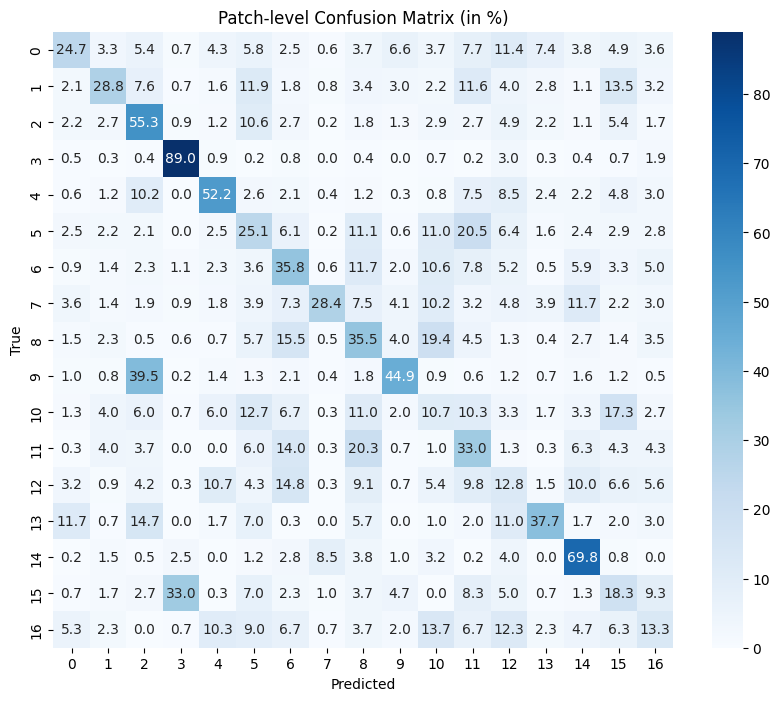

Slide-level Accuracy: 0.4807

Slide-level Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.40      0.57       377
           1       0.73      0.44      0.55        82
           2       0.49      0.76      0.60        85
           3       0.94      0.94      0.94        32
           4       0.46      0.76      0.58        17
           5       0.16      0.29      0.21        21
           6       0.67      0.56      0.61        50
           7       0.96      0.45      0.61        60
           8       0.33      0.50      0.40        22
           9       0.62      0.45      0.52       105
          10       0.00      0.00      0.00         3
          11       0.04      0.67      0.07         3
          12       0.02      0.08      0.03        12
          13       0.06      0.67      0.11         3
          14       0.12      0.75      0.21         4
          15       0.03      0.33      0.05         3
          16   

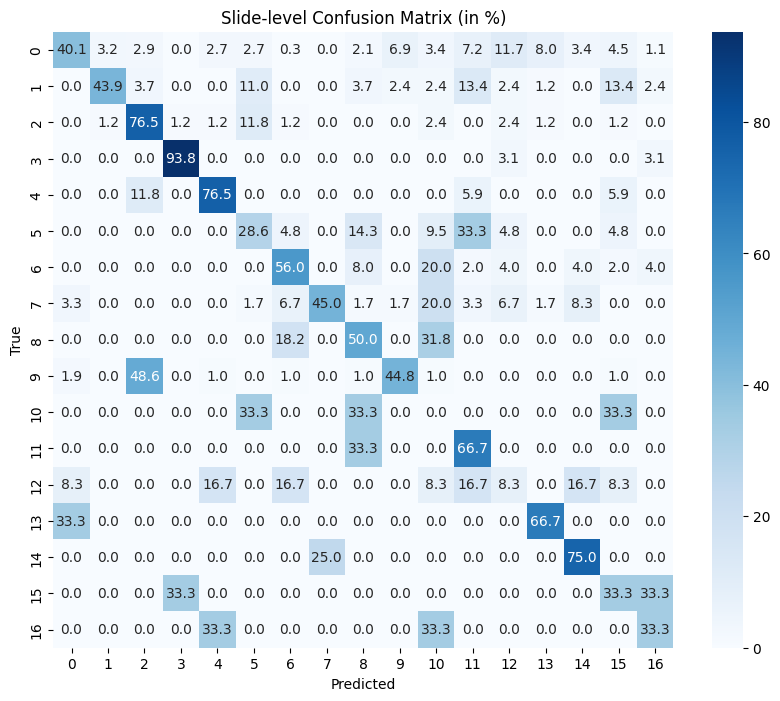

In [ ]:
test_loss /= len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# Patch-level Classification Report and Confusion Matrix
print("\nPatch-level Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(17)]))

cm_patch = confusion_matrix(all_labels, all_preds)
cm_patch_percentage = cm_patch.astype('float') / cm_patch.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_patch_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(17)], yticklabels=[str(i) for i in range(17)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Patch-level Confusion Matrix (in %)')
plt.show()



# Generate slide-level predictions
slide_preds = {}
for slide_id, preds in slide_predictions.items():
    # Majority vote or averaging probabilities can be used
    slide_preds[slide_id] = Counter(preds).most_common(1)[0][0]  # Majority vote

# Prepare slide-level true labels and predictions for evaluation
slide_true_labels = [label for slide_id, label in slide_labels.items()]
slide_pred_labels = [pred for slide_id, pred in slide_preds.items()]

# Calculate slide-level accuracy
slide_corrects = sum([1 if pred == true else 0 for pred, true in zip(slide_pred_labels, slide_true_labels)])
slide_accuracy = slide_corrects / len(slide_true_labels)

print(f"Slide-level Accuracy: {slide_accuracy:.4f}")

# Slide-level Classification Report and Confusion Matrix
print("\nSlide-level Classification Report:\n")
print(classification_report(slide_true_labels, slide_pred_labels, target_names=[str(i) for i in range(17)]))

cm_slide = confusion_matrix(slide_true_labels, slide_pred_labels)
cm_slide_percentage = cm_slide.astype('float') / cm_slide.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_slide_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=[str(i) for i in range(17)], yticklabels=[str(i) for i in range(17)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Slide-level Confusion Matrix (in %)')
plt.show()

